<p align="center">
  <img src="https://user-images.githubusercontent.com/90031508/183531098-494a5819-7714-4f72-8ff8-d038982eb5f0.png" alt="Water Oracle logo"/>
</p>



# Manual Pytesting - overcoming permission problem and MAC M1 chip tensorflow installation

This Work is adapted from 'Tensorflow example workflows', 
https://developers.google.com/earth-engine/guides/tf_examples examples.
Copyright 2020 Google LLC. https://www.apache.org/licenses/LICENSE-2.0.

Please run this notebook on google colab (pro+)

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/drive/1cRvhjD0407YfCaQDA-Y_pKN496YnsV0T?usp=sharing">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/ese-msc-2021/irp-kl121"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Introduction


## Prerequisites
- Google account and logins
- Google colab subscription with pro or pro+ is optional but would help with long runtime
- Google cloud platform account in order to use google cloud bucket. (Note that you would need sufficient funds to store large amount of models and training data.)
- Wandb.ai account which is free of charge

## What is this notebook?

Although, some pytests were already automatically integrated with github, namely the `config.py`, `losses.py`, `metrics_.py` some tests were not possible on the apple mac M1 machine. This is because of the tensorflow installation issue, the need to pay virtual machine to connect to google cloud bucket and authorization of the earth engine module. Hence, running pytest on google colab is suitable. Overall, the pytest is done in a both automatic and manual way

In this notebook we will cover the pytest for 
- <b> `metrics_.py`</b> which requires the need to use the models.py function from tensorflow module that the Mac M1 chip cannot do.
- <b>`preprocessing.py`</b> to test for imports of training, evaluation and testing data from the google cloud bucket. The connection to google cloud bucket is overcame by using google colab. Also, the ee permisssion...
- <b> `config.py` </b> config.py is an important function, although it is already tested automatically, we will use config.py function throughout the problem.
- <b> `model.py` </b> Testing the model whether it is properly training the model. It is neccesary to do the test here due to apple M1 chip incompatability with the latest tensorflow
- <b> `sampling.py` </b> Connection to GCB requires proper authentication and logins to GCB and is much more straight forward to test in colab.
- <b> `images.py` </b> This file involves communicating with the google cloud bucket and using the tensorflow module hence the test must be done in colab

## Creating Packages

Creating the tools packages that will be used throughout the notebook. The package includes 
- metrics_.py
- config.py
- preprocessing.py
- sampling.py
- losses_.py
- images.py

In [ ]:
PACKAGE_PATH = 'tools'

!ls -l
!mkdir {PACKAGE_PATH}
!touch {PACKAGE_PATH}/__init__.py
!ls -l {PACKAGE_PATH}

total 8
drwxr-xr-x 1 root root 4096 Aug 15 13:44 sample_data
drwxr-xr-x 2 root root 4096 Aug 24 13:12 tools
mkdir: cannot create directory ‘tools’: File exists
total 20
-rw-r--r-- 1 root root  2859 Aug 24 13:12 config.py
-rw-r--r-- 1 root root     0 Aug 24 13:26 __init__.py
-rw-r--r-- 1 root root 15033 Aug 24 13:12 metrics_.py


In [ ]:
%%writefile {PACKAGE_PATH}/metrics_.py

from keras import backend as K
import tqdm.notebook as tq
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

CONFIG = None

__all__ = ["f1", "custom_accuracy", "MetricCalculator",
           "MetricCalculator_multiview_2", "MetricCalculator_multiview_3",
           "MetricCalculator_NDWI", "ndwi_threashold"]


def f1(y_true, y_pred):
    """
    The function is used as tensorflow metrics when training.
    It takes in the ground truth and the model predicted result
    and evaluate the F1 score. This is an experimental function
    and should not be used as further model training metric.

    Parameters
    ----------
    y_true : tf.tensor
    y_pred : tf.tensor

    Returns
    ----------
    F1 score in keras backend

    Notes
    -----
    This function is flawed because keras calculates the metrics batchwise
    which is why F1 metric is removed from keras. To properly calulate the
    F1 score, we can use the callback function or manually calculate F1
    score after the model has finished training. The latter is chosen
    and this could be seen in MetricCalculator, MetricCalculator_multiview_2
    and MetricCalculator_multiview_3.

    The reason this function is kept is because the model was initially
    trained with these metrics and stored in the google cloud bucket.
    To retrieve the models these metrics must be passed inorder
    to retrieve the model. Since the model is optimize on the loss rather
    than the metrics, the incorrect metric would not effect the model
    training process. The code is obtained/modified from:

    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

    https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
    """
    def recall(y_true, y_pred):
        """
        Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """
        Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


def custom_accuracy(y_true, y_pred):
    """
    The function is used as tensorflow metrics when training.
    It takes in the ground truth and the model predicted result
    and evaluate the accuracy score. This is an experimental function
    and should not be used as further model training metric.

    Parameters
    ----------
    y_true : tf.tensor
    y_pred : tf.tensor

    Returns
    ----------
    accuracy score in keras backend

    Notes
    -----
    This function is modified from the F1 metric above to fit
    the definition of accuracy. However, tensorflow's
    "categorical_accuracy" is used instead. The accuracy metric
    would also be recalculated again in MetricCalculator,
    MetricCalculator_multiview_2 and MetricCalculator_multiview_3.

    The reason this function is kept is because the model was
    initially trained with these metrics and stored in
    the google cloud bucket. To retrieve the models these
    metrics must be passed inorder to retrieve the model.
    Since the model is optimize on the loss rather than
    the metrics, the incorrect metric would not effect
    the model training process. The code is obtained/modified from:

    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

    https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
    """
    # total_data = K.int_shape(y_true) + K.int_shape(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    true_negatives = K.sum(K.round(K.clip(1 - y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    total_data = - true_positives + true_negatives + \
        possible_positives + predicted_positives
    return (true_positives + true_negatives) / (total_data + K.epsilon())


def MetricCalculator(model, test_data, total_steps):
    """
    This function takes in the feature stack model loaded
    from google cloud bucket, the test_data which is the
    tensor object and the number of steps and returns
    the metrics including accuracy, recall, precision and F1

    Parameters
    ----------
    model : keras.engine.functional.Functional
    test_data : RepeatDataset with tf.float32
    total_steps : int/float

    Returns
    ----------
    Returns the precision, recall, f1, accuracy
    metric based on the model performance.

    Notes
    -----
    This function should be used instead of the F1, custom_accuracy
    written above. The code is obtained/modified from:

    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

    https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
    """
    pred = []
    true = []
    pbar = tq.tqdm(total=total_steps)
    for steps, data in enumerate(test_data):
        pbar.update(1)
        if steps == total_steps:
            break
        input = data[0]
        y_true = data[1]
        y_pred = np.rint(model.predict(input))
        y_true = np.reshape(y_true, (256 * 256, 2))
        y_pred = np.reshape(y_pred, (256 * 256, 2))
        pred.append(y_pred)
        true.append(y_true)
    f1_macro = f1_score(np.reshape(true, (total_steps * 65536, 2)),
                        np.reshape(pred, (total_steps * 65536, 2)),
                        average="macro")
    recall_macro = recall_score(np.reshape(true, (total_steps * 65536, 2)),
                                np.reshape(pred, (total_steps * 65536, 2)),
                                average="macro")
    precision_macro = precision_score(np.reshape(true,
                                      (total_steps * 65536, 2)),
                                      np.reshape(pred,
                                      (total_steps * 65536, 2)),
                                      average="macro")
    accuracy = accuracy_score(np.reshape(true, (total_steps * 65536, 2)),
                              np.reshape(pred, (total_steps * 65536, 2)))

    print("precision_macro: ", precision_macro)
    print("recall_macro: ", recall_macro)
    print("F1_macro_Score: : ", f1_macro)
    print("Accuracy: ", accuracy)

    return precision_macro, recall_macro, f1_macro, accuracy


def MetricCalculator_multiview_2(model, test_data, total_steps):
    """
    This function takes in the multiview-2 model loaded
    from google cloud bucket, the test_data which is the
    tensor object and the number of steps and returns
    the metrics including accuracy, recall, precision and F1

    Parameters
    ----------
    model : keras.engine.functional.Functional
    test_data : RepeatDataset with tf.float32
    total_steps : int/float

    Returns
    ----------
    Returns the precision, recall, f1, accuracy metric
    based on the model performance.

    Notes
    -----
    This function should be used instead of the F1,
    custom_accuracy written above. The code is obtained/modified from:

    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

    https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
    """
    pbar = tq.tqdm(total=total_steps)
    pred = []
    true = []
    for steps, data in enumerate(test_data):
        pbar.update(1)
        if steps >= total_steps:
            break
        input = data[0]
        x1, x2 = tf.split(input, [len(CONFIG.BANDS1), len(CONFIG.BANDS2)], 3)
        y_true = data[1]
        y_pred = np.rint(model.predict([x1, x2]))
        y_true = np.reshape(y_true, (256 * 256, 2))
        y_pred = np.reshape(y_pred, (256 * 256, 2))
        pred.append(y_pred)
        true.append(y_true)
    f1_macro = f1_score(np.reshape(true, (total_steps * 65536, 2)),
                        np.reshape(pred, (total_steps * 65536, 2)),
                        average="macro")
    recall_macro = recall_score(np.reshape(true, (total_steps * 65536, 2)),
                                np.reshape(pred, (total_steps * 65536, 2)),
                                average="macro")
    precision_macro = precision_score(np.reshape(true,
                                      (total_steps * 65536, 2)),
                                      np.reshape(pred,
                                      (total_steps * 65536, 2)),
                                      average="macro")
    accuracy = accuracy_score(np.reshape(true, (total_steps * 65536, 2)),
                              np.reshape(pred, (total_steps * 65536, 2)))

    print("precision_macro: ", precision_macro)
    print("recall_macro: ", recall_macro)
    print("F1_macro_Score: : ", f1_macro)
    print("Accuracy: ", accuracy)

    return precision_macro, recall_macro, f1_macro, accuracy


def MetricCalculator_multiview_3(model, test_data, total_steps):
    """
    This function takes in the multiview-3 model loaded from
    google cloud bucket, the test_data which is the tensor object
    and the number of steps and returns the metrics including
    accuracy, recall, precision and F1

    Parameters
    ----------
    model : keras.engine.functional.Functional
    test_data : RepeatDataset with tf.float32
    total_steps : int/float

    Returns
    ----------
    Returns the precision, recall, f1,
    accuracy metric based on the model performance.

    Notes
    -----
    This function should be used instead of the F1,
    custom_accuracy written above. The code is obtained/modified from:

    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

    https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
    """
    pbar = tq.tqdm(total=total_steps)
    pred = []
    true = []
    for steps, data in enumerate(test_data):
        pbar.update(1)
        if steps >= total_steps:
            break
        input = data[0]
        x1, x2, x3 = tf.split(input,
                              [len(CONFIG.BANDS1),
                               len(CONFIG.BANDS2),
                               len(CONFIG.BANDS3)],
                              3)
        y_true = data[1]
        y_pred = np.rint(model.predict([x1, x2, x3]))
        y_true = np.reshape(y_true, (256 * 256, 2))
        y_pred = np.reshape(y_pred, (256 * 256, 2))
        pred.append(y_pred)
        true.append(y_true)
    f1_macro = f1_score(np.reshape(true, (total_steps * 65536, 2)),
                        np.reshape(pred, (total_steps * 65536, 2)),
                        average="macro")
    recall_macro = recall_score(np.reshape(true, (total_steps * 65536, 2)),
                                np.reshape(pred, (total_steps * 65536, 2)),
                                average="macro")
    precision_macro = precision_score(np.reshape(true,
                                      (total_steps * 65536, 2)),
                                      np.reshape(pred,
                                      (total_steps * 65536, 2)),
                                      average="macro")
    accuracy = accuracy_score(np.reshape(true, (total_steps * 65536, 2)),
                              np.reshape(pred, (total_steps * 65536, 2)))

    print("precision_macro: ", precision_macro)
    print("recall_macro: ", recall_macro)
    print("F1_macro_Score: : ", f1_macro)
    print("Accuracy: ", accuracy)

    return precision_macro, recall_macro, f1_macro, accuracy


def ndwi_threashold(B3, B5):
    """
    This function takes in bands 3 and bands 5 from the landsat
    imagery and returns the tuple prediction of whether
    there is water present or not. The threashold is set at 0.

    Parameters
    ----------
    test_data : RepeatDataset with tf.float32
    total_steps : int/float

    Returns
    ----------
    tuple of whether there is water or not
    """
    ndwi = (B3 - B5) / (B3 + B5)
    if ndwi > 0:
        return 0, 1
    else:
        return 1, 0


def MetricCalculator_NDWI(test_data, total_steps):
    """
    This function takes in the test_data which is the tensor object and
    the number of steps and returns the metrics including accuracy,
    recall, precision and F1 for NDWI performance.

    Parameters
    ----------
    test_data : RepeatDataset with tf.float32
    total_steps : int/float

    Returns
    ----------
    Returns the precision, recall, f1, accuracy metric
    based on the NDWI performance
    """
    pred = []
    true = []
    pbar = tq.tqdm(total=total_steps)
    for steps, data in enumerate(test_data):
        # print(f'Number of steps: {steps}', end = "\r")
        pbar.update(1)
        if steps == total_steps:
            break
        input = data[0]
        y_true = data[1]
        input = np.reshape(input, (256 * 256, 2))
        y_pred = []
        for i in range(256 * 256):
            B3, B5 = input[i]
            first, second = ndwi_threashold(B3, B5)
            y_pred.append([first, second])
        y_true = np.reshape(y_true, (256 * 256, 2))
        y_pred = np.reshape(y_pred, (256 * 256, 2))
        pred.append(y_pred)
        true.append(y_true)
    f1_macro = f1_score(np.reshape(true, (total_steps * 65536, 2)),
                        np.reshape(pred, (total_steps * 65536, 2)),
                        average="macro")
    recall_macro = recall_score(np.reshape(true, (total_steps * 65536, 2)),
                                np.reshape(pred, (total_steps * 65536, 2)),
                                average="macro")
    precision_macro = precision_score(np.reshape(true,
                                                 (total_steps * 65536, 2)),
                                      np.reshape(pred,
                                                 (total_steps * 65536, 2)),
                                      average="macro")
    accuracy = accuracy_score(np.reshape(true, (total_steps * 65536, 2)),
                              np.reshape(pred, (total_steps * 65536, 2)))

    print("precision_macro: ", precision_macro)
    print("recall_macro: ", recall_macro)
    print("F1_macro_Score: : ", f1_macro)
    print("Accuracy: ", accuracy)

    return precision_macro, recall_macro, f1_macro, accuracy


Overwriting tools/metrics_.py


In [ ]:
%%writefile {PACKAGE_PATH}/config.py

import tensorflow as tf
from . import metrics_

__all__ = ["configuration"]


class configuration:
    """
    In each experiment, the combinations of satellite's bands that is
    used to train the neural network is different. Also the way to train
    the neural network is also different, whether it is feature stack,
    multiview learning with two or three perceptrons. As each experiment
    has different settings, it is important to store them and reuse this
    throughout the project. This class enables user to store the settings
    and reuse the settings.
    """
    def __init__(self, PROJECT_TITLE, BANDS1, TRAIN_SIZE, EVAL_SIZE,
                 BANDS2=[], BANDS3=[], country="TH", image=None, sam_arr=None,
                 type_=1, LOSS="categorical_crossentropy", EPOCHS=10,
                 BATCH_SIZE=16, dropout_prob=0.3):
        """

        Initialising/storing the parameters to use later

        Parameters
        ----------
        PROJECT_TITLE : string
        BANDS1 : list
        TRAIN_SIZE : int/float
        EVAL_SIZE : int/float
        BANDS2 : list
        BANDS3 : list
        country : string
        image : ee.image.Image
        sam_arr : ee.image.Image
        type : int/float

        """
        if type_ == 1:
            self.type_ = "fs"
        elif type_ == 2:
            self.type_ = "m2"
        elif type_ == 3:
            self.type_ = "m3"
        else:
            self.type_ = None
        self.country = country
        self.PROJECT_TITLE = PROJECT_TITLE
        self.BANDS1 = BANDS1
        self.BANDS2 = BANDS2
        self.BANDS3 = BANDS3
        self.BUCKET = "geebucketwater"
        self.FOLDER = f'{self.type_}_{self.country}_Cnn_{self.PROJECT_TITLE}'
        self.TRAIN_SIZE = TRAIN_SIZE
        self.EVAL_SIZE = EVAL_SIZE
        self.BUCKET = "geebucketwater"
        self.TRAINING_BASE = 'training_patches'
        self.EVAL_BASE = 'eval_patches'
        self.TEST_BASE = 'test_patches'
        self.RESPONSE = 'water'
        self.BANDS = BANDS1 + BANDS2 + BANDS3
        self.FEATURES = BANDS1 + BANDS2 + BANDS3 + [self.RESPONSE]
        # Specify the size and shape of patches expected by the model.
        self.KERNEL_SIZE = 256
        self.KERNEL_SHAPE = [self.KERNEL_SIZE, self.KERNEL_SIZE]
        self.COLUMNS = [
            tf.io.FixedLenFeature(shape=self.KERNEL_SHAPE, dtype=tf.float32)
            for k in self.FEATURES
        ]
        self.FEATURES_DICT = dict(zip(self.FEATURES, self.COLUMNS))
        # Specify model training parameters.
        self.BATCH_SIZE = BATCH_SIZE
        self.EPOCHS = EPOCHS
        self.BUFFER_SIZE = 2000
        self.OPTIMIZER = 'adam'
        self.LOSS = LOSS
        self.dropout_prob = dropout_prob
        self.METRICS = ['AUC', "categorical_accuracy", metrics_.f1]
        self.image = image
        self.sam_arr = sam_arr


Overwriting tools/config.py


In [ ]:
%%writefile {PACKAGE_PATH}/preprocessing.py

import tensorflow as tf
import ee

__all__ = ["Preprocessor", "maskL8sr", "EnsureTwodigit",
           "GenSeasonalDatesMonthly", "getQABits", "cloud_shadows",
           "clouds", "maskClouds", "applyScaleFactors", "changeNames"]


class Preprocessor:
    """
    Class that preprocessese and returns the training,
    evaluation and testing data from google cloud bucket
    """
    def __init__(self, config):
        self.config = config

    def parse_tfrecord(self, example_proto):
        """
        The parsing function Read a serialized example
        into the structure defined by FEATURES_DICT.

        Parameters
        ----------
        example_proto: a serialized Example

        Returns
        ----------
        A dictionary of tensors, keyed by feature name.

        Notes
        -----
        The code is obtained/modified from:

        https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
        """
        return tf.io.parse_single_example(example_proto,
                                          self.config.FEATURES_DICT)

    def to_tuple(self, inputs):
        """
        Function to convert a dictionary of tensors to a
        tuple of (inputs, outputs). Turn the tensors returned
        by parse_tfrecord into a stack in HWC shape.
        Parameters
        ----------
        inputs: A dictionary of tensors, keyed by feature name.

        Returns
        ----------
        A tuple of (inputs, outputs).

        Notes
        -----
        The code is obtained/modified from:

        https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
        """
        inputsList = [inputs.get(key) for key in self.config.FEATURES]
        stacked = tf.stack(inputsList, axis=0)
        # Convert from CHW to HWC
        stacked = tf.transpose(stacked, [1, 2, 0])
        return stacked[:, :, :len(self.config.BANDS)], \
            tf.reshape(tf.one_hot(
                tf.cast(stacked[:, :, len(self.config.BANDS):],
                        tf.int32),
                depth=2), [256, 256, 2])

    def get_dataset(self, pattern):
        """
        Function to read, parse and format to tuple a
        set of input tfrecord files. Get all the files
        matching the pattern, parse and convert to tuple.

        Parameters
        ----------
        pattern: A file pattern to match in a Cloud Storage bucket.

        Returns
        ----------
        A tf.data.Dataset

        Notes
        -----
        The code is obtained/modified from:

        https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
        """
        try:
            glob = tf.io.gfile.glob(pattern)
        except: # noqa
            return "the bucket you specified doesn't exist"
        if glob == []:
            return "the path you specified doesn't have the data"
        dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
        dataset = dataset.map(self.parse_tfrecord, num_parallel_calls=5)
        dataset = dataset.map(self.to_tuple, num_parallel_calls=5)
        return dataset

    def get_training_dataset(self, location):
        """
        Get the preprocessed training dataset
        Parameters
        ----------
        location: string

        Returns
        ----------
        A tf.data.Dataset of training data.

        Notes
        -----
        The code is obtained/modified from:

        https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
        """
        glob = 'gs://' + self.config.BUCKET + \
            '/' + location + "training_patches_" + '*'
        dataset = self.get_dataset(glob)
        dataset = dataset.shuffle(self.config.BUFFER_SIZE).\
            batch(self.config.BATCH_SIZE).\
            repeat()
        return dataset

    def get_training_dataset_for_testing(self, location):
        """
        Get the preprocessed training dataset for testing
        Parameters
        ----------
        location: string

        Returns
        ----------
        A tf.data.Dataset of training data.

        Notes
        -----
        The code is obtained/modified from:

        https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
        """
        glob = 'gs://' + self.config.BUCKET + \
               '/' + location + "training_patches_" + '*'
        dataset = self.get_dataset(glob)
        if type(dataset) == str:
            return dataset
        dataset = dataset.batch(1).repeat()
        return dataset

    def get_eval_dataset(self, location):
        """
        Get the preprocessed evaluation dataset
        Parameters
        ----------
        location: string

        Returns
        ----------
        A tf.data.Dataset of evaluation data.

        Notes
        -----
        The code is obtained/modified from:

        https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
        """
        glob = 'gs://' + self.config.BUCKET + \
               '/' + location + "eval_patches_" + '*'
        dataset = self.get_dataset(glob)
        if type(dataset) == str:
            return dataset
        dataset = dataset.batch(1).repeat()
        return dataset

    # print(iter(evaluation.take(1)).next())

    def get_test_dataset(self, location, test_base):
        """
        Get the preprocessed testing dataset
        Parameters
        ----------
        location: string

        Returns
        ----------
        A tf.data.Dataset of testing data.

        Notes
        -----
        The code is obtained/modified from:

        https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
        """
        glob = 'gs://' + self.config.BUCKET + \
               '/' + location + test_base + '*'
        dataset = self.get_dataset(glob)
        if type(dataset) == str:
            return dataset
        dataset = dataset.batch(1).repeat()
        return dataset


def maskL8sr(image):
    """
    Get the landsat-8 image and returned a cloud masked image
    ----------
    image: ee.image.Image

    Returns
    ----------
    A maksed landsat-8 ee.image.Image

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
    cloudShadowBitMask = ee.Number(2).pow(3).int()
    cloudsBitMask = ee.Number(2).pow(5).int()
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
        qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask).select(BANDS).divide(10000)


def EnsureTwodigit(number):
    """
    Transform the input month into string in the
    correct format for date and time.
    ----------
    number: int

    Returns
    ----------
    months in string.

    """
    if number > 12:
        return str(12)
    if number < 10:
        return "0" + str(number)
    else:
        return str(number)


def GenSeasonalDatesMonthly(start, end, month_frequency=3):
    """
    Given two dictionary containing the key month and year,
    return two arrays that contains the time between the
    interval of start and end.
    ----------
    start: dict
    end: dict

    Returns
    ----------
    Two arrays containing the time elapsed between start and end

    """
    diff_year = end["year"] - start["year"]
    diff_month = end["month"] - start["month"]
    starts = []
    ends = []
    first_data = str(start["year"]) + "-" + \
        EnsureTwodigit(start["month"]) + "-01"
    if diff_year > 0:
        return "please insert the same year"
    else:
        for i in range(round(diff_month / month_frequency)):
            first_data = str(start["year"]) + "-" + \
                EnsureTwodigit(start["month"] + month_frequency * i) + "-01"
            second_data = str(start["year"]) + "-" + \
                EnsureTwodigit(start["month"] +
                               month_frequency *
                               i +
                               month_frequency) + "-01"
            starts.append(first_data)
            ends.append(second_data)
    return starts, ends


# As collection 1 of Landsat-8 ceased at
# December 2021, collection 2 must be used instead


def getQABits(image, start, end, newName):
    """
    Compute the bits we need to extract.
    ----------
    image: ee.image.Image
    start: int
    end: int
    newName: string

    Returns
    ----------
    Return a single band image of the extracted QA bits
    with a new name

    Notes
    ----------
    Code is modified from
    https://gis.stackexchange.com/questions/277059/cloud-mask-for-landsat8-on-google-earth-engine
    """
    pattern = 0
    for i in range(start, end + 1):
        pattern += 2**i
    return image.select([0], [newName])\
                .bitwiseAnd(pattern)\
                .rightShift(start)


def cloud_shadows(image):
    """
    return the masked cloud shadow image from QABits image.
    ----------
    image: ee.image.Image

    Returns
    ----------
    Return an image masking out cloudy areas.

    Notes
    -----
    Code is modified from
    https://gis.stackexchange.com/questions/277059/cloud-mask-for-landsat8-on-google-earth-engine
    """
    # Select the QA band.
    QA = image.select(['QA_PIXEL'])
    # Get the internal_cloud_algorithm_flag bit.
    return getQABits(QA, 3, 3, 'cloud_shadows').eq(0)


def clouds(image):
    """
    Mask out cloudy pixels from QABit image.
    ----------
    image: ee.image.Image

    Returns
    ----------
    Return an image masking out cloudy areas.

    Notes
    -----
    Code is modified from
    https://gis.stackexchange.com/questions/277059/cloud-mask-for-landsat8-on-google-earth-engine
    """
    # Select the QA band.
    QA = image.select(['QA_PIXEL'])
    # Get the internal_cloud_algorithm_flag bit.
    return getQABits(QA, 5, 5, 'Cloud').eq(0)
    # Return an image masking out cloudy areas.


def maskClouds(image):
    """
    Put all the functions together to mask the clouds and
    shadows
    ----------
    image: ee.image.Image

    Returns
    ----------
    Return an image masking out cloudy and shadow area.

    Notes
    -----
    Code is modified from
    https://gis.stackexchange.com/questions/277059/cloud-mask-for-landsat8-on-google-earth-engine
    """
    cs = cloud_shadows(image)
    c = clouds(image)
    image = image.updateMask(cs)
    return image.updateMask(c)


def applyScaleFactors(image):
    """
    Adjust scale factor to standardize the visualization
    ----------
    image: ee.image.Image

    Returns
    ----------
    Adjusted image with correct scale factor

    Notes
    -----
    Code is modified from
    https://gis.stackexchange.com/questions/277059/cloud-mask-for-landsat8-on-google-earth-engine
    """
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True)\
                .addBands(thermalBands, None, True)


def changeNames(image):
    """
    Adjust bandNames of collection 2 to match collection 1
    ----------
    image: ee.image.Image

    Returns
    ----------
    ee.image.Image with adjusted bandNames
    """
    return image.select(['SR_B1', 'SR_B2', 'SR_B3',
                         'SR_B4', 'SR_B5', 'SR_B6',
                         'SR_B7', 'SR_QA_AEROSOL',
                         'ST_B10', 'ST_ATRAN', 'ST_CDIST',
                         'ST_DRAD', 'ST_EMIS', 'ST_EMSD',
                         'ST_QA', 'ST_TRAD', 'ST_URAD',
                         'QA_PIXEL', 'QA_RADSAT'],
                        ['B1', 'B2', 'B3', 'B4', 'B5',
                         'B6', 'B7', 'SR_QA_AEROSOL',
                         'ST_B10', 'ST_ATRAN', 'ST_CDIST',
                         'ST_DRAD', 'ST_EMIS', 'ST_EMSD',
                         'ST_QA', 'ST_TRAD', 'ST_URAD',
                         'QA_PIXEL', 'QA_RADSAT'])


Writing tools/preprocessing.py


In [ ]:
%%writefile {PACKAGE_PATH}/model.py

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers

CONFIG = None

__all__ = ["conv_block", "EncoderMiniBlock", "DecoderMiniBlock",
           "CustomModel", "get_model", "CustomModel_multiview_2",
           "get_model_multiview_2", "CustomModel_multiview_3",
           "get_model_multiview_3", "get_model_multiview_2_HT"]


def conv_block(input_tensor, num_filters):
    """
    This is processes the tensor right after the encoder
    to give the center block. The function takes in input tensor
    and number of filters and returns the next layer which is the
    center layer.

    Parameters
    ----------
    input_tensor : tf.float32/tf.int
    num_filters : int/float

    Returns
    ----------
    returns the next layer which is the center layer which is a tensor object

    Notes
    -----
    The code is obtained/modified from:

    https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder


def EncoderMiniBlock(inputs, num_filters=32,
                     dropout_prob=0.3, max_pooling=True):
    """
    Encoder miniblock that will enable creation of all other encoder layers in
    the get_model function. The function takes in inputs, number of filter,
    a dropout probability and max_pooling parameter. The function
    returns the next layer and the corresponding layer which will
    be used in decoding later on.

    Parameters
    ----------
    input_tensor : tf.float32/tf.int
    num_filters : int/float
    dropout_prob : float
    max_pooling : bool

    Returns
    ----------
    The function returns the next layer and the corresponding layer which
    will be used in decoding later on as a tensor object

    Notes
    -----
    The code is obtained/modified from:

    https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    conv = layers.Conv2D(num_filters,
                         3,  # filter size
                         activation='relu',
                         padding='same',
                         kernel_initializer='HeNormal')(inputs)
    conv = layers.Conv2D(num_filters,
                         3,  # filter size
                         activation='relu',
                         padding='same',
                         kernel_initializer='HeNormal')(conv)

    conv = layers.BatchNormalization()(conv, training=False)
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv
    skip_connection = conv
    return next_layer, skip_connection


def DecoderMiniBlock(prev_layer_input, skip_layer_input, num_filters=32):
    """
    Decoder miniblock will enable creation of all other
    decoder layers in the get_model function.
    The function takes in the previous layer inputs,
    the corresponding encoder and number of filters.
    The function returns the next layer and the corresponding
    layer which will be used in decoding later on.

    Parameters
    ----------
    prev_layer_input : tf.float32/tf.int
    skip_layer_input : tf.float32/tf.int
    num_filters : int/float

    Returns
    ----------
    The function returns the next layer and the corresponding
    layer which will be used in decoding later on as a tensor object

    Notes
    -----
    The code is obtained/modified from:

    https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    up = layers.Conv2DTranspose(
        num_filters,
        (3, 3),
        strides=(2, 2),
        padding='same')(prev_layer_input)
    merge = layers.concatenate([up, skip_layer_input], axis=3)
    conv = layers.Conv2D(num_filters,
                         3,
                         activation='relu',
                         padding='same',
                         kernel_initializer='HeNormal')(merge)
    conv = layers.Conv2D(num_filters,
                         3,
                         activation='relu',
                         padding='same',
                         kernel_initializer='HeNormal')(conv)
    return conv


class CustomModel(tf.keras.Model):
    """
    This class allows us to create custom model by modifying
    the functions of interest including the train_step test_step
    in order to enable the model to take in multilayered inputs.
    Also, the execution is switched from
    eager to graph in order to increase the speed of training

    Notes
    -----
    The code is obtained/modified from:

    https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6#:~:text=Eager%20execution%20is%20a%20powerful,they%20occur%20in%20your%20code.

    https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    """
    @tf.function
    def train_step(self, data):
        """
        This function is a standard train_step in tensorflow,
        but graph execution is used instead. The function
        takes in the data and return the corresponding metrics

        Parameters
        ----------
        data : tuple of tf.float32/tf.int

        Returns
        ----------
        The function returns the corresponding metrics
        """
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y,
                                      y_pred,
                                      regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        """
        This function is a standard test_step in tensorflow,
        but graph execution is used instead.
        The function takes in the data and
        return the corresponding metrics

        Parameters
        ----------
        data : tuple of tf.float32/tf.int

        Returns
        ----------
        The function returns the corresponding metrics
        """
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


def get_model():
    """
    This function puts all the previous mini encoders,
    decoder and conv_block and the modified custom model
    together in order to compile and return a customized
    model for feature stack method.

    Notes
    -----
    The code is obtained/modified from:

    https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6#:~:text=Eager%20execution%20is%20a%20powerful,they%20occur%20in%20your%20code.

    https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    """
    inputs = layers.Input(shape=[None, None, len(CONFIG.BANDS)])  # 256
    encoder0_pool, encoder0 = EncoderMiniBlock(inputs, 32)  # 128
    encoder1_pool, encoder1 = EncoderMiniBlock(encoder0_pool, 64)  # 64
    encoder2_pool, encoder2 = EncoderMiniBlock(encoder1_pool, 128)  # 32
    encoder3_pool, encoder3 = EncoderMiniBlock(encoder2_pool, 256)  # 16
    encoder4_pool, encoder4 = EncoderMiniBlock(encoder3_pool, 512)  # 8
    center = conv_block(encoder4_pool, 1024)  # center
    decoder4 = DecoderMiniBlock(center, encoder4, 512)  # 16
    decoder3 = DecoderMiniBlock(decoder4, encoder3, 256)  # 32
    decoder2 = DecoderMiniBlock(decoder3, encoder2, 128)  # 64
    decoder1 = DecoderMiniBlock(decoder2, encoder1, 64)  # 128
    decoder0 = DecoderMiniBlock(decoder1, encoder0, 32)  # 256
    outputs = layers.Dense(2, activation=tf.nn.softmax)(decoder0)

    model_custom = CustomModel(inputs, outputs)

    model_custom.compile(
        optimizer=optimizers.get(CONFIG.OPTIMIZER),
        loss=losses.get(CONFIG.LOSS),
        metrics=[CONFIG.METRICS]
    )
    return model_custom


class CustomModel_multiview_2(tf.keras.Model):
    """
    This class allows us to create custom model by
    modifying the functions of interest including the train_step
    test_step in order to enable the model to take in 2 layer
    inputs for multiview learning. Also, the execution is switched from
    eager to graph in order to increase the speed of training

    Notes
    -----
    The code is obtained/modified from:

    https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6#:~:text=Eager%20execution%20is%20a%20powerful,they%20occur%20in%20your%20code.

    https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    """
    @tf.function
    def train_step(self, data):
        """
        This function modifies the standard train_step in
        tensorflow in order to manipulate and split the
        input data to put into the multiview deep learning model,
        and graph execution is used instead.
        The function takes in the data and return the corresponding
        metrics.

        Parameters
        ----------
        data : tuple of tf.float32/tf.int

        Returns
        ----------
        The function returns the corresponding metrics
        """
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        x1, x2 = tf.split(x, [len(CONFIG.BANDS1), len(CONFIG.BANDS2)], 3)
        # print(x.numpy())

        with tf.GradientTape() as tape:
            y_pred = self([x1, x2], training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y,
                                      y_pred,
                                      regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        """
        This function modifies the standard test_step in tensorflow
        in order to manipulate and split the input data to put into
        the multiview deep learning model, and graph execution is used instead.
        The function takes in the data and return the corresponding metrics

        Parameters
        ----------
        data : tuple of tf.float32/tf.int

        Returns
        ----------
        The function returns the corresponding metrics
        """
        # Unpack the data
        x, y = data
        x1, x2 = tf.split(x, [len(CONFIG.BANDS1), len(CONFIG.BANDS2)], 3)
        # Compute predictions
        y_pred = self([x1, x2], training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


def get_model_multiview_2():
    """
    This function puts all the previous mini encoders,
    decoder and conv_block and the modified custom model
    together in order to compile and return a customized
    model for multiview learning with 2 inputs

    Notes
    -----
    The code is obtained/modified from:

    https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6#:~:text=Eager%20execution%20is%20a%20powerful,they%20occur%20in%20your%20code.

    https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    """
    # First input
    first_input = layers.Input(shape=[None, None, len(CONFIG.BANDS1)])  # 256
    # Encoding section
    first_encoder0_pool, first_encoder0 = \
        EncoderMiniBlock(first_input, 32)  # 128
    first_encoder1_pool, first_encoder1 = \
        EncoderMiniBlock(first_encoder0_pool, 64)  # 64
    first_encoder2_pool, first_encoder2 = \
        EncoderMiniBlock(first_encoder1_pool, 128)  # 32
    first_encoder3_pool, first_encoder3 = \
        EncoderMiniBlock(first_encoder2_pool, 256)  # 16
    first_encoder4_pool, first_encoder4 = \
        EncoderMiniBlock(first_encoder3_pool, 512)  # 8
    # Center block
    first_center = conv_block(first_encoder4_pool, 1024)
    # Decoding
    first_decoder4 = \
        DecoderMiniBlock(first_center, first_encoder4, 512)  # 16
    first_decoder3 = \
        DecoderMiniBlock(first_decoder4, first_encoder3, 256)  # 32
    first_decoder2 = \
        DecoderMiniBlock(first_decoder3, first_encoder2, 128)  # 64
    first_decoder1 = \
        DecoderMiniBlock(first_decoder2, first_encoder1, 64)  # 128
    first_decoder0 = \
        DecoderMiniBlock(first_decoder1, first_encoder0, 32)  # 256

    # Second input
    second_input = layers.Input(shape=[None, None, len(CONFIG.BANDS2)])  # 256
    # Encoding section
    second_encoder0_pool, second_encoder0 = \
        EncoderMiniBlock(second_input, 32)  # 128
    second_encoder1_pool, second_encoder1 = \
        EncoderMiniBlock(second_encoder0_pool, 64)  # 64
    second_encoder2_pool, second_encoder2 = \
        EncoderMiniBlock(second_encoder1_pool, 128)  # 32
    second_encoder3_pool, second_encoder3 = \
        EncoderMiniBlock(second_encoder2_pool, 256)  # 16
    second_encoder4_pool, second_encoder4 = \
        EncoderMiniBlock(second_encoder3_pool, 512)  # 8
    # Center block
    second_center = conv_block(second_encoder4_pool, 1024)  # center
    # Decoder section
    second_decoder4 = \
        DecoderMiniBlock(second_center, second_encoder4, 512)  # 16
    second_decoder3 = \
        DecoderMiniBlock(second_decoder4, second_encoder3, 256)  # 32
    second_decoder2 = \
        DecoderMiniBlock(second_decoder3, second_encoder2, 128)  # 64
    second_decoder1 = \
        DecoderMiniBlock(second_decoder2, second_encoder1, 64)  # 128
    second_decoder0 = \
        DecoderMiniBlock(second_decoder1, second_encoder0, 32)  # 256

    # Fuse two features
    concat_output = tf.keras.layers.concatenate([first_decoder0,
                                                 second_decoder0],
                                                name='cca_output')
    outputs = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(concat_output)

    model_custom = CustomModel_multiview_2([first_input,
                                            second_input],
                                           outputs)
    model_custom.compile(
        optimizer=optimizers.get(CONFIG.OPTIMIZER),
        loss=losses.get(CONFIG.LOSS),
        metrics=[CONFIG.METRICS])
    return model_custom


class CustomModel_multiview_3(tf.keras.Model):
    """
    This class allows us to create custom model by modifying
    the functions of interest including the train_step test_step
    in order to enable the model to take in 3 layer inputs for
    multiview learning. Also, the execution is switched from
    eager to graph in order to increase the speed of training

    Notes
    -----
    The code is obtained/modified from:

    https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6#:~:text=Eager%20execution%20is%20a%20powerful,they%20occur%20in%20your%20code.

    https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    """
    @tf.function
    def train_step(self, data):
        """
        This function modifies the standard train_step in tensorflow
        in order to manipulate and split the input data to put into
        the multiview deep learning model, and graph execution is used instead.
        The function takes in the data and return the corresponding metrics

        Parameters
        ----------
        data : tuple of tf.float32/tf.int

        Returns
        ----------
        The function returns the corresponding metrics
        """
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        x1, x2, x3 = tf.split(x,
                              [len(CONFIG.BANDS1),
                               len(CONFIG.BANDS2),
                               len(CONFIG.BANDS3)],
                              3)

        with tf.GradientTape() as tape:
            y_pred = self([x1, x2, x3], training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y,
                                      y_pred,
                                      regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        """
        This function modifies the standard test_step in
        tensorflow in order to manipulate and split the
        input data to put into the multiview deep learning
        model, and graph execution is used instead.
        The function takes in the data and return the
        corresponding metrics

        Parameters
        ----------
        data : tuple of tf.float32/tf.int

        Returns
        ----------
        The function returns the corresponding metrics
        """
        # Unpack the data
        x, y = data
        x1, x2, x3 = tf.split(x,
                              [len(CONFIG.BANDS1),
                               len(CONFIG.BANDS2),
                               len(CONFIG.BANDS3)],
                              3)
        # Compute predictions
        y_pred = self([x1, x2, x3], training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


def get_model_multiview_3():
    """
    This function puts all the previous mini encoders,
    decoder and conv_block and the modified custom model
    together in order to compile and return a customized
    model for multiview learning with 3 inputs

    Notes
    -----
    The code is obtained/modified from:

    https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6#:~:text=Eager%20execution%20is%20a%20powerful,they%20occur%20in%20your%20code.

    https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    """
    # First input
    first_input = layers.Input(shape=[None, None, len(CONFIG.BANDS1)])  # 256
    # Encoder section
    first_encoder0_pool, first_encoder0 = \
        EncoderMiniBlock(first_input, 32)  # 128
    first_encoder1_pool, first_encoder1 = \
        EncoderMiniBlock(first_encoder0_pool, 64)  # 64
    first_encoder2_pool, first_encoder2 = \
        EncoderMiniBlock(first_encoder1_pool, 128)  # 32
    first_encoder3_pool, first_encoder3 = \
        EncoderMiniBlock(first_encoder2_pool, 256)  # 16
    first_encoder4_pool, first_encoder4 = \
        EncoderMiniBlock(first_encoder3_pool, 512)  # 8
    # Center Block
    first_center = conv_block(first_encoder4_pool, 1024)
    # Decoder section
    first_decoder4 = \
        DecoderMiniBlock(first_center, first_encoder4, 512)  # 16
    first_decoder3 = \
        DecoderMiniBlock(first_decoder4, first_encoder3, 256)  # 32
    first_decoder2 = \
        DecoderMiniBlock(first_decoder3, first_encoder2, 128)  # 64
    first_decoder1 = \
        DecoderMiniBlock(first_decoder2, first_encoder1, 64)  # 128
    first_decoder0 = \
        DecoderMiniBlock(first_decoder1, first_encoder0, 32)  # 256

    # Second Input
    second_input = layers.Input(shape=[None, None, len(CONFIG.BANDS2)])  # 256
    # Encoder Section
    second_encoder0_pool, second_encoder0 = \
        EncoderMiniBlock(second_input, 32)  # 128
    second_encoder1_pool, second_encoder1 = \
        EncoderMiniBlock(second_encoder0_pool, 64)  # 64
    second_encoder2_pool, second_encoder2 = \
        EncoderMiniBlock(second_encoder1_pool, 128)  # 32
    second_encoder3_pool, second_encoder3 = \
        EncoderMiniBlock(second_encoder2_pool, 256)  # 16
    second_encoder4_pool, second_encoder4 = \
        EncoderMiniBlock(second_encoder3_pool, 512)  # 8
    # Center block
    second_center = conv_block(second_encoder4_pool, 1024)
    # Decoder section
    second_decoder4 = \
        DecoderMiniBlock(second_center, second_encoder4, 512)  # 16
    second_decoder3 = \
        DecoderMiniBlock(second_decoder4, second_encoder3, 256)  # 32
    second_decoder2 = \
        DecoderMiniBlock(second_decoder3, second_encoder2, 128)  # 64
    second_decoder1 = \
        DecoderMiniBlock(second_decoder2, second_encoder1, 64)  # 128
    second_decoder0 = \
        DecoderMiniBlock(second_decoder1, second_encoder0, 32)  # 256

    # Third input
    third_input = layers.Input(shape=[None, None, len(CONFIG.BANDS3)])  # 256
    # Encoder section
    third_encoder0_pool, third_encoder0 = \
        EncoderMiniBlock(third_input, 32)  # 128
    third_encoder1_pool, third_encoder1 = \
        EncoderMiniBlock(third_encoder0_pool, 64)  # 64
    third_encoder2_pool, third_encoder2 = \
        EncoderMiniBlock(third_encoder1_pool, 128)  # 32
    third_encoder3_pool, third_encoder3 = \
        EncoderMiniBlock(third_encoder2_pool, 256)  # 16
    third_encoder4_pool, third_encoder4 = \
        EncoderMiniBlock(third_encoder3_pool, 512)  # 8
    # Center Block
    third_center = conv_block(third_encoder4_pool, 1024)
    # Decoder Section
    third_decoder4 = \
        DecoderMiniBlock(third_center, third_encoder4, 512)  # 16
    third_decoder3 = \
        DecoderMiniBlock(third_decoder4, third_encoder3, 256)  # 32
    third_decoder2 = \
        DecoderMiniBlock(third_decoder3, third_encoder2, 128)  # 64
    third_decoder1 = \
        DecoderMiniBlock(third_decoder2, third_encoder1, 64)  # 128
    third_decoder0 = \
        DecoderMiniBlock(third_decoder1, third_encoder0, 32)  # 256

    # Fuse two features
    concat_output = tf.keras.layers.concatenate([first_decoder0,
                                                 second_decoder0,
                                                 third_decoder0],
                                                name='cca_output')
    outputs = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(concat_output)

    model_custom = CustomModel_multiview_3([first_input,
                                            second_input,
                                            third_input],
                                           outputs)

    model_custom.compile(
        optimizer=optimizers.get(CONFIG.OPTIMIZER),
        loss=losses.get(CONFIG.LOSS),
        metrics=[CONFIG.METRICS])
    return model_custom


def get_model_multiview_2_HT():
    """
    This function puts all the previous mini encoders,
    decoder and conv_block and the modified custom model
    together in order to compile and return a customized
    model for multiview learning with 2 inputs. This function
    is also used in hyperparameter tuning for loss functions
    and dropouts rate.

    Notes
    -----
    The code is obtained/modified from:

    https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6#:~:text=Eager%20execution%20is%20a%20powerful,they%20occur%20in%20your%20code.

    https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    """
    # First input
    first_input = layers.Input(shape=[None, None, len(CONFIG.BANDS1)])  # 256
    # First encoder
    first_encoder0_pool, first_encoder0 = \
        EncoderMiniBlock(first_input,
                         32,
                         dropout_prob=CONFIG.dropout_prob)  # 128
    first_encoder1_pool, first_encoder1 = \
        EncoderMiniBlock(first_encoder0_pool,
                         64,
                         dropout_prob=CONFIG.dropout_prob)  # 64
    first_encoder2_pool, first_encoder2 = \
        EncoderMiniBlock(first_encoder1_pool,
                         128,
                         dropout_prob=CONFIG.dropout_prob)  # 32
    first_encoder3_pool, first_encoder3 = \
        EncoderMiniBlock(first_encoder2_pool,
                         256,
                         dropout_prob=CONFIG.dropout_prob)  # 16
    first_encoder4_pool, first_encoder4 = \
        EncoderMiniBlock(first_encoder3_pool,
                         512,
                         dropout_prob=CONFIG.dropout_prob)  # 8
    # Center Block
    first_center = conv_block(first_encoder4_pool, 1024)  # center
    # First Decoder
    first_decoder4 = \
        DecoderMiniBlock(first_center,
                         first_encoder4,
                         512)  # 16
    first_decoder3 = \
        DecoderMiniBlock(first_decoder4,
                         first_encoder3,
                         256)  # 32
    first_decoder2 = \
        DecoderMiniBlock(first_decoder3,
                         first_encoder2,
                         128)  # 64
    first_decoder1 = \
        DecoderMiniBlock(first_decoder2, first_encoder1, 64)  # 128
    first_decoder0 = \
        DecoderMiniBlock(first_decoder1, first_encoder0, 32)  # 256

    # Second input
    second_input = layers.Input(shape=[None, None, len(CONFIG.BANDS2)])  # 256
    # Second Encoder
    second_encoder0_pool, second_encoder0 = \
        EncoderMiniBlock(second_input, 32)  # 128
    second_encoder1_pool, second_encoder1 = \
        EncoderMiniBlock(second_encoder0_pool, 64)  # 64
    second_encoder2_pool, second_encoder2 = \
        EncoderMiniBlock(second_encoder1_pool, 128)  # 32
    second_encoder3_pool, second_encoder3 = \
        EncoderMiniBlock(second_encoder2_pool, 256)  # 16
    second_encoder4_pool, second_encoder4 = \
        EncoderMiniBlock(second_encoder3_pool, 512)  # 8
    # Center Block
    second_center = conv_block(second_encoder4_pool, 1024)
    # Second Decoder Block
    second_decoder4 = \
        DecoderMiniBlock(second_center, second_encoder4, 512)  # 16
    second_decoder3 = \
        DecoderMiniBlock(second_decoder4, second_encoder3, 256)  # 32
    second_decoder2 = \
        DecoderMiniBlock(second_decoder3, second_encoder2, 128)  # 64
    second_decoder1 = \
        DecoderMiniBlock(second_decoder2, second_encoder1, 64)  # 128
    second_decoder0 = \
        DecoderMiniBlock(second_decoder1, second_encoder0, 32)  # 256

    # Fuse two features
    concat_output = tf.keras.layers.concatenate([first_decoder0,
                                                 second_decoder0],
                                                name='cca_output')
    outputs = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(concat_output)

    model_custom = CustomModel_multiview_2([first_input,
                                            second_input],
                                           outputs)
    model_custom.compile(
        optimizer=optimizers.get(CONFIG.OPTIMIZER),
        loss=CONFIG.LOSS,
        metrics=[CONFIG.METRICS])
    return model_custom


Writing tools/model.py


In [ ]:
%%writefile {PACKAGE_PATH}/sampling.py

import ee

__all__ = ["Training_task", "Eval_task", "Testing_task"]


def Training_task(trainingPolys, n, N, arrays, setting, foldername):
    """
    Exporting Training data to google cloud bucket
    Parameters
    ----------
    trainingPolys : ee.featurecollection.FeatureCollection
    n : int/float
    N : int/float
    arrays: ee.image.Image
    setting: tools.config.configuration
    foldername : string

    Returns
    ----------
    A tf.data.Dataset of testing data.

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    trainingPolysList = trainingPolys.toList(trainingPolys.size())
    # Export all the training data (in many pieces), ith one task
    # per geometry.
    for g in range(trainingPolys.size().getInfo()):
        geomSample = ee.FeatureCollection([])
        for i in range(n):
            sample = arrays.sample(
                region=ee.Feature(trainingPolysList.get(g)).geometry(),
                scale=30,
                numPixels=N / n,
                seed=i,
                tileScale=8
            )
        geomSample = geomSample.merge(sample)

        desc = setting.TRAINING_BASE + '_g' + str(g)
        task = ee.batch.Export.table.toCloudStorage(
            collection=geomSample,
            description=desc,
            bucket=setting.BUCKET,
            fileNamePrefix=foldername + '/' + desc,
            fileFormat='TFRecord',
            selectors=setting.BANDS + [setting.RESPONSE]
        )
        task.start()


def Eval_task(evalPolys, n, N, arrays, setting, foldername):
    """
    Exporting Evaluating data to google cloud bucket
    Parameters
    ----------
    evalPolys : ee.featurecollection.FeatureCollection
    n : int/float
    N : int/float
    arrays: ee.image.Image
    setting: tools.config.configuration
    foldername : string

    Returns
    ----------
    A tf.data.Dataset of testing data.

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    evalPolysList = evalPolys.toList(evalPolys.size())
    # Export all the evaluation data.
    for g in range(evalPolys.size().getInfo()):
        geomSample = ee.FeatureCollection([])
        for i in range(n):
            sample = arrays.sample(
                region=ee.Feature(evalPolysList.get(g)).geometry(),
                scale=30,
                numPixels=N / n,
                seed=i,
                tileScale=8
            )
            geomSample = geomSample.merge(sample)

        desc = setting.EVAL_BASE + '_g' + str(g)
        task = ee.batch.Export.table.toCloudStorage(
            collection=geomSample,
            description=desc,
            bucket=setting.BUCKET,
            fileNamePrefix=foldername + '/' + desc,
            fileFormat='TFRecord',
            selectors=setting.BANDS + [setting.RESPONSE]
        )
        task.start()


def Testing_task(testPolys, n, N, arrays, setting, foldername, Test_base):
    """
    Exporting Testing data to google cloud bucket
    Parameters
    ----------
    testPolys : ee.featurecollection.FeatureCollection
    n : int/float
    N : int/float
    arrays: ee.image.Image
    setting: tools.config.configuration
    foldername : string

    Returns
    ----------
    A tf.data.Dataset of testing data.

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    # Export all the test data.
    testPolysList = testPolys.toList(testPolys.size())
    for g in range(testPolys.size().getInfo()):
        geomSample = ee.FeatureCollection([])
        for i in range(n):
            sample = arrays.sample(
                region=ee.Feature(testPolysList.get(g)).geometry(),
                scale=30,
                numPixels=N / n,
                seed=i,
                tileScale=8
            )
            geomSample = geomSample.merge(sample)

        desc = Test_base + '_g' + str(g)
        task = ee.batch.Export.table.toCloudStorage(
            collection=geomSample,
            description=desc,
            bucket=setting.BUCKET,
            fileNamePrefix=foldername + '/' + desc,
            fileFormat='TFRecord',
            selectors=setting.BANDS + [setting.RESPONSE]
        )
        task.start()


Writing tools/sampling.py


In [ ]:
%%writefile {PACKAGE_PATH}/losses_.py

import keras.backend as K
from keras.losses import categorical_crossentropy


__all__ = ["dice_coef", "dice_p_cc"]


def dice_coef(y_true, y_pred, smooth=1):
    """
    Recieve the true and predicted tensor and return the resulting dice loss
    to prevent overfitting.
    ----------
    y_true: tf.float32
    y_pred: tf.float32
    smooth: int/float

    Returns
    ----------
    A tf.float32 with same dimension as input tf.float32

    Notes
    -----
    The code is obtained/modified from:

    https://www.kaggle.com/code/kmader/u-net-with-dice-and-augmentation/notebook
    """
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)


def dice_p_cc(in_gt, in_pred):
    """
    Recieve the true and predicted tensor
    and return the resulting categorical
    dice loss
    ----------
    in_gt: tf.float32
    in_pred: tf.float32

    Returns
    ----------
    A tf.float32 with same dimension as input tf.float32

    Notes
    -----
    The code is obtained/modified from:

    https://www.kaggle.com/code/kmader/u-net-with-dice-and-augmentation/notebook
    """
    return categorical_crossentropy(in_gt, in_pred) - \
        K.log(dice_coef(in_gt, in_pred))


Writing tools/losses_.py


In [ ]:
%%writefile {PACKAGE_PATH}/images.py

from pprint import pprint
import numpy as np
import tqdm.notebook as tq
import tensorflow as tf
import ee
import subprocess
import ast


__all__ = ["doExport", "predictionSingleinput", "predictionMultipleinput",
           "predictionMultipleinput_3", "uploadToGEEAsset", "LoadImage",
           "doPrediction_featurestack", "doPrediction_multiview_2",
           "doPrediction_multiview_3"]


def doExport(out_image_base, kernel_buffer, region, setting, extra_folder=""):
    """
    Export the image with features and area of interest
    to google cloud bucket. The function doesn't exit until
    the task is complete. The optional extra_folder arguement lets you put
    the exported tf.record.gz in a folder

    Parameters
    ----------
    out_image_base : string
    kernel_buffer : list
    region : ee.Geometry.BBox
    setting : dict
    extra_folder : string

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    if extra_folder == "":
        fileNamePrefix_ = setting.FOLDER + '/' + out_image_base
    else:
        fileNamePrefix_ = setting.FOLDER + '/' + extra_folder + '/' + out_image_base # noqa
    task = ee.batch.Export.image.toCloudStorage(
        image=setting.image.select(setting.BANDS),
        description=out_image_base,
        bucket=setting.BUCKET,
        fileNamePrefix=fileNamePrefix_,
        region=region.getInfo()['coordinates'],
        scale=30,
        fileFormat='TFRecord',
        maxPixels=1e10,
        formatOptions={
            'patchDimensions': setting.KERNEL_SHAPE,
            'kernelSize': kernel_buffer,
            'compressed': True,
            'maxFileSize': 104857600
        }
    )
    task.start()

    # Block until the task completes.
    print('Running image export to Cloud Storage...')
    import time
    while task.active():
        time.sleep(30)

    # Error condition
    if task.status()['state'] != 'COMPLETED':
        print('Error with image export.')
    else:
        print('Image export completed.')


def LoadImage(out_image_base, user_folder, kernel_buffer, setting, extra_folder=""): # noqa
    """
    Load the image from the google cloud bucket and preprocess the
    image for prediction and provide crutial information for
    exporting to GEE asset

    Parameters
    ----------
    out_image_base : string
    user_folder : string
    kernel_buffer : list
    setting : dict
    extra_folder : string

    Notes
    -----
    The code is obtained/modified from:

    Returns
    ----------
    imageDataset as tensor data for prediction, patches as int,
    x_buffer as int, y_buffer as int, jsonFile as string

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    print('Looking for TFRecord files...')

    # Get a list of all the files in the output bucket.
    if extra_folder == "":
        process = subprocess.run(["gsutil", "ls",
                                  f'gs://{setting.BUCKET}/{setting.FOLDER}'],
                                 stdout=subprocess.PIPE,
                                 stderr=subprocess.PIPE,
                                 text=True)
        filesList = process.stdout.split('\n')
    else:
        process = subprocess.run(["gsutil", "ls",
                                  f'gs://{setting.BUCKET}/{setting.FOLDER}/{extra_folder}'], # noqa
                                 stdout=subprocess.PIPE,
                                 stderr=subprocess.PIPE,
                                 text=True)
        filesList = process.stdout.split('\n')

    print(filesList)
    # Get only the files generated by the image export.
    exportFilesList = [s for s in filesList if out_image_base in s]
    print(exportFilesList)
    # Get the list of image files and the JSON mixer file.
    imageFilesList = []
    jsonFile = None
    for f in exportFilesList:
        if f.endswith('.tfrecord.gz'):
            imageFilesList.append(f)
        elif f.endswith('.json'):
            jsonFile = f

    # Make sure the files are in the right order.
    imageFilesList.sort()

    pprint(imageFilesList)
    print(jsonFile)
    if jsonFile is None:
        return "image path doesn't exist"

    # Load the contents of the mixer file to a JSON object.
    process = subprocess.run(["gsutil", "cat", f'{jsonFile}'],
                             stdout=subprocess.PIPE,
                             stderr=subprocess.PIPE,
                             text=True)
    jsonText = process.stdout
    # Get a single string w/ newlines from the IPython.utils.text.SList
    # mixer = json.loads(jsonText.nlstr)
    mixer = ast.literal_eval(jsonText)
    pprint(mixer)
    patches = mixer['totalPatches']

    # Get set up for prediction.
    x_buffer = int(kernel_buffer[0] / 2)
    y_buffer = int(kernel_buffer[1] / 2)

    buffered_shape = [
        setting.KERNEL_SHAPE[0] + kernel_buffer[0],
        setting.KERNEL_SHAPE[1] + kernel_buffer[1]]

    imageColumns = [
        tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32) for k in setting.BANDS # noqa
    ]

    def parse_image(example_proto):
        """
        The parsing function Read a serialized example into
        the structure defined by FEATURES_DICT.

        Parameters
        ----------
        example_proto: a serialized Example

        Returns
        ----------
        A dictionary of tensors, keyed by feature name.

        Notes
        -----
        The code is obtained/modified from:

        https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
        """
        return tf.io.parse_single_example(example_proto, imageFeaturesDict)

    def toTupleImage(inputs):
        """
        Function to convert a dictionary of tensors to a tuple of
        (inputs, outputs). Turn the tensors returned by
        parse_tfrecord into a stack in HWC shape.
        Parameters
        ----------
        inputs: A dictionary of tensors, keyed by feature name.

        Returns
        ----------
        A tuple of (inputs, outputs).

        Notes
        -----
        The code is obtained/modified from:

        https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
        """
        inputsList = [inputs.get(key) for key in setting.BANDS]
        stacked = tf.stack(inputsList, axis=0)
        stacked = tf.transpose(stacked, [1, 2, 0])
        return stacked

    imageFeaturesDict = dict(zip(setting.BANDS, imageColumns))
    imageDataset = tf.data.TFRecordDataset(imageFilesList,
                                           compression_type='GZIP')
    imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
    imageDataset = imageDataset.map(toTupleImage).batch(1)
    return imageDataset, patches, x_buffer, y_buffer, jsonFile


def predictionSingleinput(model, imageDataset, patches):
    """
    Given the model, and image for prediction, predict the image
    with feature stack U-Net

    Parameters
    ----------
    model : model : keras.engine.functional.Functional
    imageDataset : tf.data.Dataset of training data (BatchDataset)
    patches : int

    Returns
    ----------
    A tf.float32 with same dimension as imageDataset

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    print('Running predictions...')
    predictions = model.predict(imageDataset, steps=patches, verbose=1)
    return predictions


def predictionMultipleinput(model, imageDataset, patches, setting):
    """
    Given the model, and image for prediction, predict the image
    with Multi-view learning U-Net

    Parameters
    ----------
    model : model : keras.engine.functional.Functional
    imageDataset : tf.data.Dataset of training data (BatchDataset)
    patches : int
    setting : dict

    Returns
    ----------
    A tf.float32 with same dimension as imageDataset

    Notes
    -----
    The code is modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    print('Running predictions...')
    predictions = []
    pbar = tq.tqdm(total=patches)
    for data in imageDataset:
        pbar.update(1)
        x1, x2 = tf.split(data, [len(setting.BANDS1), len(setting.BANDS2)], 3)
        predictions.append(model.predict([x1, x2], verbose=0))
    return predictions


def predictionMultipleinput_3(model, imageDataset, patches, setting):
    """
    Given the model, and image for prediction, predict the image
    with Multi-view learning U-Net with 3 inputs

    Parameters
    ----------
    model : model : keras.engine.functional.Functional
    imageDataset : tf.data.Dataset of training data (BatchDataset)
    patches : int
    setting : dict

    Returns
    ----------
    A tf.float32 with same dimension as imageDataset

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    print('Running predictions...')
    predictions = []
    pbar = tq.tqdm(total=patches)
    for data in imageDataset:
        pbar.update(1)
        x1, x2, x3 = tf.split(data, [len(setting.BANDS1),
                                     len(setting.BANDS2),
                                     len(setting.BANDS3)], 3)
        predictions.append(model.predict([x1, x2, x3], verbose=0))
    return predictions


def uploadToGEEAsset(x_buffer, y_buffer, predictions, out_image_base,
                     jsonFile, suffix, setting, multiview=False,
                     user_folder='users/mewchayutaphong'):
    """
    Given the predictions, exported file location other information
    on the image to be exported, return the required information
    in order to export the predicted image to the GEE asset

    Parameters
    ----------
    x_buffer : int
    y_buffer : int
    predictions : tf.data.Dataset of training data (BatchDataset)
    out_image_base : string
    jsonFile : string
    suffix : string
    setting : dict
    user_folder : string

    Returns
    ----------
    A out_image_asset a location to the output GEE asset folder
    as a string, out_image_file of the prediction as TFRecord and the
    corresponding json file.

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    print('Writing predictions...')
    out_image_file = 'gs://' + setting.BUCKET + '/' + \
                     setting.FOLDER + '/' + out_image_base + \
                     '.TFRecord'
    writer = tf.io.TFRecordWriter(out_image_file)
    patches = 0
    for predictionPatch in predictions:
        if multiview is True:
            predictionPatch = predictionPatch[0]
        print('Writing patch ' + str(patches) + '...')
        predictionPatch = predictionPatch[
            x_buffer:x_buffer + setting.KERNEL_SIZE,
            y_buffer:y_buffer + setting.KERNEL_SIZE]
        predictionPatch = np.argmax(predictionPatch, -1)
        example = tf.train.Example(
            features=tf.train.Features(
                feature={
                    'prediction': tf.train.Feature(
                        float_list=tf.train.FloatList(
                            value=predictionPatch.flatten()))
                }
            )
        )
        # Write the prediction.
        writer.write(example.SerializeToString())
        patches += 1

    writer.close()

    # Start the upload.
    out_image_asset = user_folder + '/' + out_image_base + suffix
    return out_image_asset, out_image_file, jsonFile


def doPrediction_featurestack(out_image_base, user_folder,
                              kernel_buffer, model, suffix,
                              setting, extra_folder=""):
    """
    Putting all the image functions together. Load the Image,
    predict the output with featurestack U-Net, return information
    ready to be exported to GEE asset
    ----------
    pattern: A file pattern to match in a Cloud Storage bucket.

    Returns
    ----------
    A out_image_asset a location to the output GEE asset folder
    as a string, out_image_file of the prediction as TFRecord and the
    corresponding json file.

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    output_load_image = LoadImage(out_image_base, user_folder,
                                  kernel_buffer, setting, extra_folder)
    if type(output_load_image) == str:
        return "wrong file location"
    imageDataset, patches, x_buffer, y_buffer, jsonFile = output_load_image
    predictions = predictionSingleinput(model, imageDataset, patches)
    out_image_asset, out_image_file, jsonFile = \
        uploadToGEEAsset(x_buffer,
                         y_buffer,
                         predictions,
                         out_image_base,
                         jsonFile, suffix,
                         setting,
                         False)
    return out_image_asset, out_image_file, jsonFile


def doPrediction_multiview_2(out_image_base, user_folder,
                             kernel_buffer, model, suffix,
                             setting, extra_folder=""):
    """
    Putting all the image functions together. Load the Image,
    predict the output with Multi-view U-Net (2 inputs),
    return information ready to be exported to GEE asset
    ----------
    pattern: A file pattern to match in a Cloud Storage bucket.

    Returns
    ----------
    A out_image_asset a location to the output GEE asset folder
    as a string, out_image_file of the prediction as TFRecord and the
    corresponding json file.

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    output_load_image = LoadImage(out_image_base,
                                  user_folder,
                                  kernel_buffer,
                                  setting,
                                  extra_folder)
    if type(output_load_image) == str:
        return "wrong file location"
    imageDataset, patches, x_buffer, y_buffer, jsonFile = output_load_image
    predictions = predictionMultipleinput(model,
                                          imageDataset,
                                          patches,
                                          setting)
    out_image_asset, out_image_file, jsonFile = \
        uploadToGEEAsset(x_buffer, y_buffer, predictions,
                         out_image_base, jsonFile, suffix,
                         setting, True)
    return out_image_asset, out_image_file, jsonFile


def doPrediction_multiview_3(out_image_base, user_folder,
                             kernel_buffer, model, suffix,
                             setting, extra_folder=""):
    """
    Putting all the image functions together. Load the Image,
    predict the output with Multi-view U-Net (3 inputs),
    return information ready to be exported to GEE asset
    ----------
    pattern: A file pattern to match in a Cloud Storage bucket.

    Returns
    ----------
    A out_image_asset a location to the output GEE asset folder
    as a string, out_image_file of the prediction as TFRecord and the
    corresponding json file.

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    output_load_image = LoadImage(out_image_base,
                                  user_folder,
                                  kernel_buffer,
                                  setting,
                                  extra_folder)
    if type(output_load_image) == str:
        return "wrong file location"
    imageDataset, patches, x_buffer, y_buffer, jsonFile = output_load_image
    predictions = predictionMultipleinput_3(model,
                                            imageDataset,
                                            patches,
                                            setting)
    out_image_asset, out_image_file, jsonFile = \
        uploadToGEEAsset(x_buffer,
                         y_buffer,
                         predictions,
                         out_image_base,
                         jsonFile,
                         suffix,
                         setting,
                         True)
    return out_image_asset, out_image_file, jsonFile


Writing tools/images.py


## Authentication

Authentication with google colab, earth engine api and google cloud bucket is required before proceeding.

In [ ]:
# Cloud authentication.
from google.colab import auth
auth.authenticate_user()

# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

project_id = 'coastal-cell-299117'
!gcloud config set project {project_id}

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=4jYAmgPaLORh7ktZjAxpoQPru8mh587jcpqQpZgL-Ys&tc=6rQbf4MtHmGnrScB3TEIoHSvpAWef8bufiI9GAe-Byk&cc=RPoK5WHwmXpPm9rMwVoJEiE6FKXTxu4VHQHUKrgWjN0

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AdQt8qh0JgJ8H1YoR0kCnbjmWL7avTwxMA33buY3r5GUX2vXmhkhl7b78Nc

Successfully saved authorization token.
Updated property [core/project].



- get your private key here to authenticate Google Earth Engine: https://developers.google.com/earth-engine/guides/service_account 

- Create a cell to write your .private-key.json and paste your private key similar to the template below 

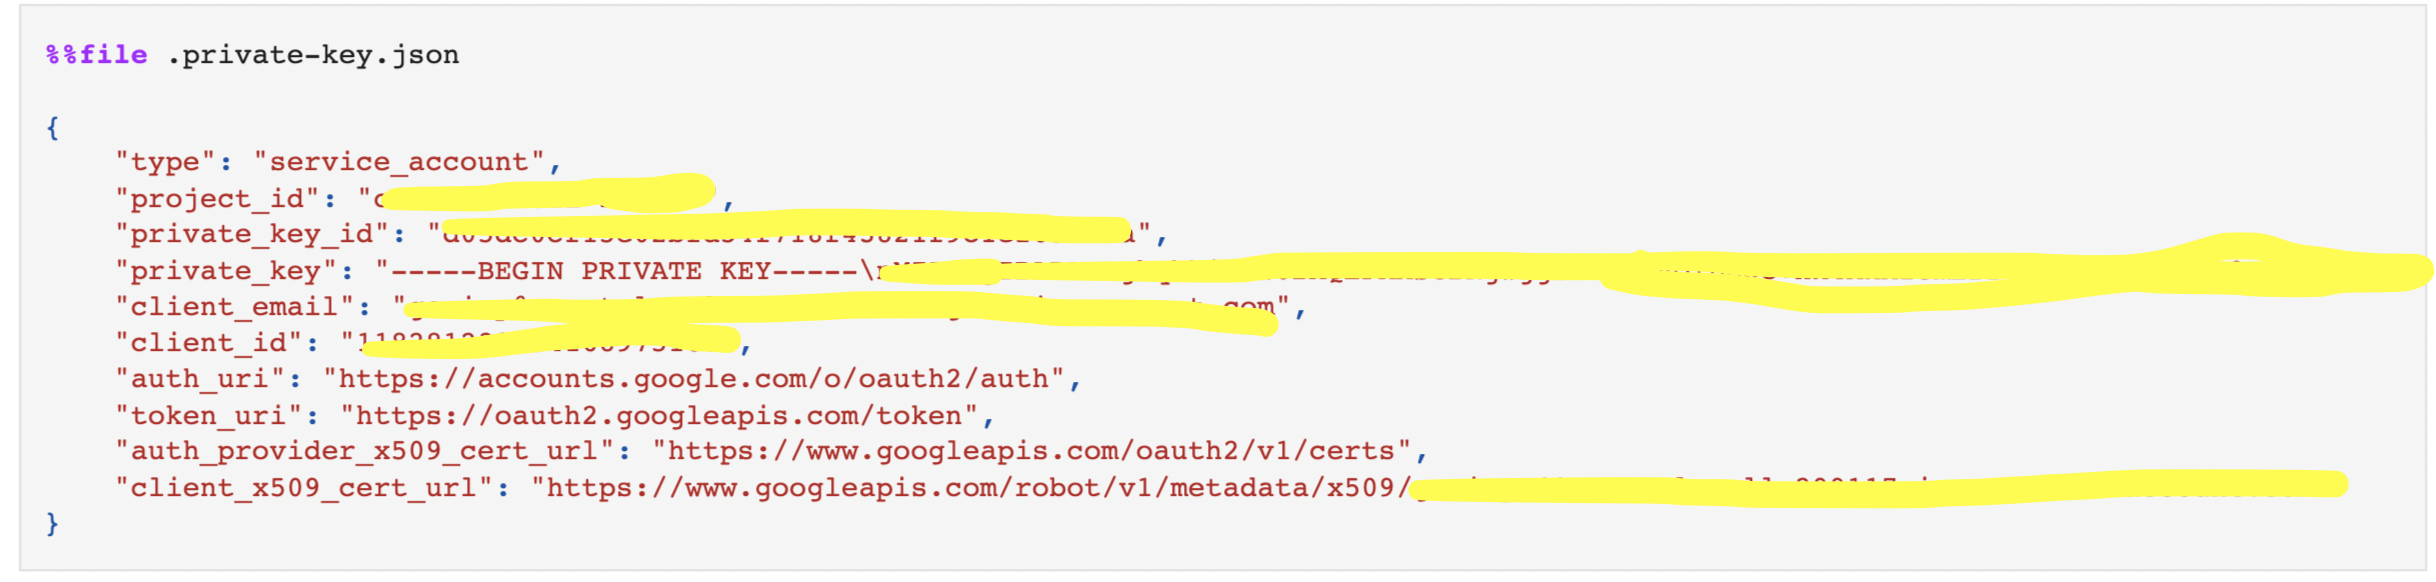

## Import other required library

In [ ]:
!pip -q install pytest pytest-sugar
import tensorflow as tf
from pprint import pprint
from tools import preprocessing, \
    config, \
    metrics_, \
    model, \
    losses_, \
    images, \
    sampling
import time
# from importlib import reload
# reload(sampling) # Uncomment this line to rerun the modified packages

# Pytest

The test is broken down into

- <b>`metrics_.py`</b> whilst using `model.py` and `config.py`
- <b>`preprocessing.py`</b> whilst using `config.py`
- <b>`model.py`</b> whilst using `config.py`
- <b>`lossses_.py`</b>
- <b>`sampling.py`</b> whilst using config.py and preprocessing.py

Followed by a compilation cell at the end. Please execute the compilation cell to see the pytest results


## Testing the <b>`metrics_.py`</b> whilst using `model.py` and `config.py`

In [ ]:
%%file test_metrics.py

from tensorflow.keras import losses
import pytest
from tools import preprocessing, config, metrics_, model
import tensorflow as tf

train_size = 1
eval_size = 1
configs = {}
configs["L8SR"] = \
    config.configuration("L8SR",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         country="global")
configs["L8SR_el_sl_as"] = \
    config.configuration("L8SR_el_sl_as",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         ["elevation", "slope", "aspect"],
                         type_=2,
                         country="global")
configs["L8SR_S1_as3"] = \
    config.configuration("L8SR_S1_as3",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         ["VV", "VH"],
                         ["aspect"],
                         type_=3,
                         country="global")
configs["L8SR_S1A_sl_CC_dp0.3"] = \
    config.configuration("L8SR_S1A_sl_CC_dp0.3",
                         BANDS1=["B2", "B3", "B4", "B5", "B6", "B7"],
                         BANDS2=["VV", "VH", "angle", "slope"],
                         TRAIN_SIZE=train_size,
                         EVAL_SIZE=eval_size,
                         EPOCHS=10,
                         BATCH_SIZE=16,
                         dropout_prob=0.3,
                         LOSS=losses.get("categorical_crossentropy"),
                         type_=2,
                         country="TH")

test_data = [(tf.random.uniform(shape=(1, 256, 256, 6)),
              tf.zeros(shape=(1, 256, 256, 2)))]
test_data_m2 = [(tf.random.uniform(shape=(1, 256, 256, 9)),
                 tf.zeros(shape=(1, 256, 256, 2)))]
test_data_m3 = [(tf.random.uniform(shape=(1, 256, 256, 9)),
                 tf.zeros(shape=(1, 256, 256, 2)))]
test_data_m2_hp = [(tf.random.uniform(shape=(1, 256, 256, 10)),
                    tf.zeros(shape=(1, 256, 256, 2)))]


@pytest.fixture(params=[test_data])
def data(request):
    return request.param


@pytest.fixture(params=[1])
def totalsteps_(request):
    return request.param


def test_Metrics(data, totalsteps_):
    model.CONFIG = configs["L8SR"]
    dummymodel = model.get_model()
    precision_macro, recall_macro, f1_macro, accuracy = \
        metrics_.MetricCalculator(dummymodel, data, totalsteps_)
    assert precision_macro <= 0 or precision_macro >= 1
    assert recall_macro <= 0 or precision_macro >= 1
    assert f1_macro <= 0 or precision_macro >= 1
    assert accuracy <= 0 or precision_macro >= 1


@pytest.fixture(params=[test_data_m2])
def data_m2(request):
    return request.param


@pytest.fixture(params=[1])
def totalsteps_m2(request):
    return request.param


def test_Metrics_2(data_m2, totalsteps_m2):
    model.CONFIG = configs["L8SR_el_sl_as"]
    metrics_.CONFIG = configs["L8SR_el_sl_as"]
    print(model.CONFIG.BANDS1, model.CONFIG.BANDS2)
    dummymodel_multiview_2 = model.get_model_multiview_2()
    precision_macro, recall_macro, f1_macro, accuracy = \
        metrics_.MetricCalculator_multiview_2(dummymodel_multiview_2,
                                              data_m2,
                                              totalsteps_m2)
    assert precision_macro <= 0 or precision_macro >= 1
    assert recall_macro <= 0 or precision_macro >= 1
    assert f1_macro <= 0 or precision_macro >= 1
    assert accuracy <= 0 or precision_macro >= 1


@pytest.fixture(params=[test_data_m3])
def data_m3(request):
    return request.param


@pytest.fixture(params=[1])
def totalsteps_m3(request):
    return request.param


def test_Metrics_3(data_m3, totalsteps_m3):
    model.CONFIG = configs["L8SR_S1_as3"]
    metrics_.CONFIG = configs["L8SR_S1_as3"]
    print(model.CONFIG.BANDS1, model.CONFIG.BANDS2)
    dummymodel_multiview_3 = model.get_model_multiview_3()
    precision_macro, recall_macro, f1_macro, accuracy = \
        metrics_.MetricCalculator_multiview_3(dummymodel_multiview_3,
                                              data_m3,
                                              totalsteps_m3)
    assert precision_macro <= 0 or precision_macro >= 1
    assert recall_macro <= 0 or precision_macro >= 1
    assert f1_macro <= 0 or precision_macro >= 1
    assert accuracy <= 0 or precision_macro >= 1


@pytest.fixture(params=[test_data_m2_hp])
def data_m2_hp(request):
    return request.param


@pytest.fixture(params=[1])
def totalsteps_m2_hp(request):
    return request.param


def test_Metrics_2_hp(data_m2_hp, totalsteps_m2_hp):
    model.CONFIG = configs["L8SR_S1A_sl_CC_dp0.3"]
    metrics_.CONFIG = configs["L8SR_S1A_sl_CC_dp0.3"]
    print(model.CONFIG.BANDS1, model.CONFIG.BANDS2)
    dummymodel_multiview_2_HT = model.get_model_multiview_2_HT()
    precision_macro, recall_macro, f1_macro, accuracy = \
        metrics_.MetricCalculator_multiview_2(dummymodel_multiview_2_HT,
                                              data_m2_hp,
                                              totalsteps_m2_hp)
    assert precision_macro <= 0 or precision_macro >= 1
    assert recall_macro <= 0 or precision_macro >= 1
    assert f1_macro <= 0 or precision_macro >= 1
    assert accuracy <= 0 or precision_macro >= 1


Writing test_metrics.py


## Testing <b>`preprocessing.py`</b> whilst using `config.py`

In [ ]:
%%file test_preprocessing.py

import pytest
from tools import preprocessing, config
import tensorflow as tf
import numpy as np
import ee
import tools.preprocessing as preprocessing
import pytest

# connection to the service account
service_account = 'geeimp@coastal-cell-299117.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account,
                                           '.private-key.json')
ee.Initialize(credentials)

train_size = 1
eval_size = 1
configs = {}
configs["L8SR"] = \
    config.configuration("L8SR",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         country="global")
configs["L8SR_el_sl_as"] = \
    config.configuration("L8SR_el_sl_as",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         ["elevation", "slope", "aspect"],
                         type_=2,
                         country="global")
configs["L8SR_S1_as3"] = \
    config.configuration("L8SR_S1_as3",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         ["VV", "VH"],
                         ["aspect"],
                         type_=3,
                         country="global")


def test_masking():
    l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').\
        filterDate('2018-01-01', '2018-02-01')
    L8SR = l8sr.map(preprocessing.maskL8sr).median()
    l8srBands = l8sr.median().bandNames().getInfo()
    L8SRmaskedBands = L8SR.bandNames().getInfo()
    assert l8srBands == \
        ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7',
         'B10', 'B11', 'sr_aerosol', 'pixel_qa', 'radsat_qa']
    assert L8SRmaskedBands == \
        ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']


def test_preprocessing():
    conf = configs["L8SR"]
    preproc = preprocessing.Preprocessor(conf)
    evaluation = preproc.get_eval_dataset("train_in_global/")
    if type(evaluation) == str:
        assert evaluation == "the path you specified doesn't have the data" \
            or evaluation == "the bucket you specified doesn't exist"
    else:
        first_evaluation = iter(evaluation.take(1)).next()
        assert (np.array(tf.shape(first_evaluation[0]))
                == np.array([1, 256, 256, 6])).all()
        assert (np.array(tf.shape(first_evaluation[1]))
                == np.array([1, 256, 256, 2])).all()


def test_preprocessing_m2():
    conf = configs["L8SR_el_sl_as"]
    preproc = preprocessing.Preprocessor(conf)
    evaluation = preproc.get_eval_dataset("train_in_global/")
    if type(evaluation) == str:
        assert evaluation == "the path you specified doesn't have the data" \
            or evaluation == "the bucket you specified doesn't exist"
    else:
        first_evaluation = iter(evaluation.take(1)).next()
        assert (np.array(tf.shape(first_evaluation[0])) ==
                np.array([1, 256, 256, 9])).all()
        assert (np.array(tf.shape(first_evaluation[1])) ==
                np.array([1, 256, 256, 2])).all()


def test_preprocessing_m3():
    conf = configs["L8SR_S1_as3"]
    preproc = preprocessing.Preprocessor(conf)
    evaluation = preproc.get_eval_dataset("train_in_global/")
    if type(evaluation) == str:
        assert evaluation == "the path you specified doesn't have the data" \
            or evaluation == "the bucket you specified doesn't exist"
    else:
        first_evaluation = iter(evaluation.take(1)).next()
        assert (np.array(tf.shape(first_evaluation[0]))
                == np.array([1, 256, 256, 9])).all()

        assert (np.array(tf.shape(first_evaluation[1]))
                == np.array([1, 256, 256, 2])).all()


def test_non_existingfile():
    configs["L8SR_S1_as3"] = \
        config.configuration("L8SR_S1_as3",
                             ["B2", "B3", "B4", "B5", "B6", "B7"],
                             train_size,
                             eval_size,
                             ["VV", "VH"],
                             ["aspect"],
                             type_=3,
                             country="global")
    conf = configs["L8SR_S1_as3"]
    preproc = preprocessing.Preprocessor(conf)
    evaluation = preproc.get_eval_dataset("train_in_globalk/")
    assert evaluation == "the path you specified doesn't have the data" or \
        evaluation == "the bucket you specified doesn't exist"


def test_wrong_bucket():
    configs["L8SR_S1_as3"] = \
        config.configuration("L8SR_S1_as3",
                             ["B2", "B3", "B4", "B5", "B6", "B7"],
                             train_size,
                             eval_size,
                             ["VV", "VH"],
                             ["aspect"],
                             type_=3,
                             country="global")
    conf = configs["L8SR_S1_as3"]
    conf.BUCKET = "asd"
    preproc = preprocessing.Preprocessor(conf)
    evaluation = preproc.get_eval_dataset("train_in_globalk/")
    assert evaluation == "the path you specified doesn't have the data" or\
        evaluation == "the bucket you specified doesn't exist"


Writing test_preprocessing.py


## Testing <b>`model.py`</b> whilst using `config.py`

In [ ]:
%%file test_model.py

from tensorflow.keras import losses
import pytest
from tools import config, model
import tensorflow as tf

train_size = 1
eval_size = 1
configs = {}
configs["L8SR"] = \
    config.configuration("L8SR",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         country="global")
configs["L8SR_el_sl_as"] = \
    config.configuration("L8SR_el_sl_as",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         ["elevation", "slope", "aspect"],
                         type_=2,
                         country="global")
configs["L8SR_S1_as3"] = \
    config.configuration("L8SR_S1_as3",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         ["VV", "VH"],
                         ["aspect"],
                         type_=3,
                         country="global")
configs["L8SR_S1A_sl_CC_dp0.3"] = \
    config.configuration("L8SR_S1A_sl_CC_dp0.3",
                         BANDS1=["B2", "B3", "B4", "B5", "B6", "B7"],
                         BANDS2=["VV", "VH", "angle", "slope"],
                         TRAIN_SIZE=train_size,
                         EVAL_SIZE=eval_size,
                         EPOCHS=10,
                         BATCH_SIZE=16,
                         dropout_prob=0.3,
                         LOSS=losses.get("categorical_crossentropy"),
                         type_=2,
                         country="TH")

test_data = [(tf.random.uniform(shape=(1, 256, 256, 6)),
              tf.zeros(shape=(1, 256, 256, 2)))]
test_data_m2 = [(tf.random.uniform(shape=(1, 256, 256, 9)),
                 tf.zeros(shape=(1, 256, 256, 2)))]
test_data_m3 = [(tf.random.uniform(shape=(1, 256, 256, 9)),
                 tf.zeros(shape=(1, 256, 256, 2)))]
test_data_m2_hp = [(tf.random.uniform(shape=(1, 256, 256, 10)),
                    tf.zeros(shape=(1, 256, 256, 2)))]


@pytest.fixture(params=[test_data])
def data(request):
    return request.param


@pytest.fixture(params=[1])
def totalsteps_(request):
    return request.param


def test_model_FS(data, totalsteps_):
    model.CONFIG = configs["L8SR"]
    dummymodel = model.get_model()
    prediction_shape = dummymodel.predict(data[0][0]).shape
    assert prediction_shape == (1, 256, 256, 2)


@pytest.fixture(params=[test_data_m2])
def data_m2(request):
    return request.param


@pytest.fixture(params=[1])
def totalsteps_(request):
    return request.param


def test_model_M2(data_m2, totalsteps_):
    model.CONFIG = configs["L8SR_el_sl_as"]
    dummymodel = model.get_model_multiview_2()
    x1, x2 = tf.split(data_m2[0][0],
                      [len(model.CONFIG.BANDS1),
                      len(model.CONFIG.BANDS2)],
                      3)
    prediction_shape = dummymodel.predict([x1, x2]).shape
    assert prediction_shape == (1, 256, 256, 2)


@pytest.fixture(params=[test_data_m3])
def data_m3(request):
    return request.param


@pytest.fixture(params=[1])
def totalsteps_(request):
    return request.param


def test_model_M3(data_m3, totalsteps_):
    model.CONFIG = configs["L8SR_S1_as3"]
    dummymodel = model.get_model_multiview_2()
    x1, x2, x3 = tf.split(data_m3[0][0],
                          [len(model.CONFIG.BANDS1),
                          len(model.CONFIG.BANDS2),
                          len(model.CONFIG.BANDS3)],
                          3)
    prediction_shape = dummymodel.predict([x1, x2]).shape
    assert prediction_shape == (1, 256, 256, 2)


@pytest.fixture(params=[test_data_m2_hp])
def data_m2_hp(request):
    return request.param


@pytest.fixture(params=[1])
def totalsteps_(request):
    return request.param


def test_model_M2_HT(data_m2_hp, totalsteps_):
    model.CONFIG = configs["L8SR_S1A_sl_CC_dp0.3"]
    dummymodel = model.get_model_multiview_2_HT()
    x1, x2 = tf.split(data_m2_hp[0][0],
                      [len(model.CONFIG.BANDS1),
                      len(model.CONFIG.BANDS2)],
                      3)
    prediction_shape = dummymodel.predict([x1, x2]).shape
    assert prediction_shape == (1, 256, 256, 2)

Writing test_model.py


## Testing `losses_.py`

In [ ]:
%%file test_losses_.py

import tools.losses_ as losses_
import pytest
import tensorflow as tf
import numpy as np

test_data = [tf.ones(shape=(1, 256, 256, 2)),
             tf.ones(shape=(1, 256, 256, 2))]


def test_dicecc():
    loss = losses_.dice_p_cc(test_data[0], test_data[1])
    assert np.isclose(float(tf.math.reduce_mean(loss)), 1.3862922191619873)


def test_dice():
    loss = losses_.dice_coef(test_data[0], test_data[1])
    print(float(tf.math.reduce_mean(loss)))
    assert np.isclose(float(tf.math.reduce_mean(loss)), 1)


Writing test_losses_.py


## Testing `sampling.py` whilst using `config.py` and `preprocessing.py`

In [ ]:
%%file test_sampling.py

import pytest
from tools import sampling, config, preprocessing
import tensorflow as tf
import numpy as np
import ee
import time

# connection to the service account
service_account = 'geeimp@coastal-cell-299117.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account,
                                           '.private-key.json')
ee.Initialize(credentials)

# Sentinel-1 Data (10m)
S1 = ee.ImageCollection('COPERNICUS/S1_GRD').\
    filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).\
    filterDate('2018-01-01', '2018-02-01') \

S1A = S1.median()
S1 = S1.select('VV', 'VH').median()

# USG’s Landsat-8 Collection 1 and Tier 1 (30m)
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').\
    filterDate('2018-01-01', '2018-02-01')

# Cloud masking function.
L8SR = l8sr.map(preprocessing.maskL8sr).median()

# NASADEM: NASA NASADEM Digital Elevation (30m)
elevation = ee.Image('NASA/NASADEM_HGT/001').select('elevation')
slope = ee.Terrain.slope(elevation)
aspect = ee.Terrain.aspect(elevation)

# JRC-Monthly Water history (30m)
waterdata = ee.ImageCollection('JRC/GSW1_3/MonthlyHistory').\
    filterDate('2018-01-01', '2018-02-01').median()
watermask = waterdata.select("water")
# masking out "no data" region
mask = watermask.gt(0)
# Shifting the labels to make it binary
maskedComposite = waterdata.updateMask(mask).subtract(1)
train_size = 720
eval_size = 72 * 3
configs = {}
configs["L8SR"] = \
    config.configuration("L8SR",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         country="global")
configs["L8SR_el_sl_as"] = \
    config.configuration("L8SR_el_sl_as",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         ["elevation", "slope", "aspect"],
                         type_=2,
                         country="global")
configs["L8SR_S1_as3"] = \
    config.configuration("L8SR_S1_as3",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         ["VV", "VH"],
                         ["aspect"],
                         type_=3,
                         country="global")
configs["L8SR"].image = L8SR.float()
configs["L8SR_el_sl_as"].image = ee.Image.cat([L8SR,
                                               elevation,
                                               slope,
                                               aspect]).\
    float()
configs["L8SR_S1_as3"].image = ee.Image.cat([L8SR, S1, aspect])


India_eval = ee.Geometry.BBox(75.68466076783874, 21.263314014804795,
                              78.04672131471374, 22.770654917923526)
Tibet_eval = ee.Geometry.BBox(93.92188430197075, 26.847874650118836,
                              95.93238234884575, 28.356873608833094)
brazil_eval = ee.Geometry.BBox(-53.749924908880686, -22.833543783979856,
                               -51.047288190130686, -20.999024800255494)

evalPolys_global = ee.FeatureCollection(Tibet_eval).\
    merge(India_eval).\
    merge(brazil_eval)

for key in list(configs):
    settings = configs[key]
    featureStack = ee.Image.cat([
        settings.image.select(settings.BANDS),
        maskedComposite.select(settings.RESPONSE)
    ]).float()
    list_ = ee.List.repeat(1, settings.KERNEL_SIZE)
    lists = ee.List.repeat(list_, settings.KERNEL_SIZE)
    kernel = ee.Kernel.fixed(settings.KERNEL_SIZE, settings.KERNEL_SIZE, lists)
    arrays = featureStack.neighborhoodToArray(kernel)
    configs[key].sam_arr = arrays
    print(key, settings.sam_arr.getInfo())


def test_wrong_bucket_sampling():
    conf = configs["L8SR_S1_as3"]
    conf.BUCKET = "asd"
    foldername = "wrongbucket"
    n = 1  # Number of shards in each polygon.
    N = 1  # Total sample size in each polygon.
    sampling.Eval_task(evalPolys_global, n, N, conf.sam_arr, conf, foldername)
    while ee.data.listOperations()[0]['metadata']['state'] == 'PENDING':
        time.sleep(3)
    if ee.data.listOperations()[2]['metadata']['state'] == 'COMPLETED':
        message = 'Image export completed.'
    elif ee.data.listOperations()[2]['metadata']['state'] == 'FAILED':
        message = 'Error with image export.'
    print(message)
    assert message == 'Error with image export.'
    # assert message == 'Image export completed.'


Writing test_sampling.py


## Testing images.py

In [ ]:
%%file test_images.py

import subprocess
subprocess.run(["gsutil", "ls", 'gs://geebucketwater/train_in_global'])

import pytest
from tools import images, config, preprocessing, model, metrics_, losses_
import tensorflow as tf
import numpy as np
import ee
import time
from tensorflow.keras import losses

# connection to the service account
service_account = 'geeimp@coastal-cell-299117.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account,
                                           '.private-key.json')
ee.Initialize(credentials)

# Sentinel-1 Data (10m)
S1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filterDate('2018-01-01', '2018-02-01') \

S1A = S1.median()
S1 = S1.select('VV', 'VH').median()

# USG’s Landsat-8 Collection 1 and Tier 1 (30m)
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').\
    filterDate('2018-01-01', '2018-02-01')

# Cloud masking function.
L8SR = l8sr.map(preprocessing.maskL8sr).median()

# NASADEM: NASA NASADEM Digital Elevation (30m)
elevation = ee.Image('NASA/NASADEM_HGT/001').select('elevation')
slope = ee.Terrain.slope(elevation)
aspect = ee.Terrain.aspect(elevation)

test_data = [(tf.random.uniform(shape=(1, 256, 256, 6)),
              tf.zeros(shape=(1, 256, 256, 2)))]
test_data_m2 = [(tf.random.uniform(shape=(1, 256, 256, 9)),
                 tf.zeros(shape=(1, 256, 256, 2)))]
test_data_m3 = [(tf.random.uniform(shape=(1, 256, 256, 9)),
                 tf.zeros(shape=(1, 256, 256, 2)))]

train_size = 720
eval_size = 72 * 3
configs = {}
configs["L8SR"] = \
    config.configuration("L8SR",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         country="global")
configs["L8SR_el_sl_as"] = \
    config.configuration("L8SR_el_sl_as",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         ["elevation", "slope", "aspect"],
                         type_=2,
                         country="global")
configs["L8SR_S1_as3"] = \
    config.configuration("L8SR_S1_as3",
                         ["B2", "B3", "B4", "B5", "B6", "B7"],
                         train_size,
                         eval_size,
                         ["VV", "VH"],
                         ["aspect"],
                         type_=3,
                         country="global")
configs["L8SR"].image = L8SR.float()
configs["L8SR_el_sl_as"].image = \
    ee.Image.cat([L8SR, elevation, slope, aspect]).float()
configs["L8SR_S1_as3"].image = ee.Image.cat([L8SR, S1, aspect])


tb_region = ee.Geometry.BBox(94.72188430197075, 28.047874650118836,
                             94.93238234884575, 28.356873608833094)
tb_image_base = 'Tibet_with_Multi_seasonalEXP_'
kernel_buffer = [128, 128]


def test_pred_single_input():
    model.CONFIG = configs["L8SR"]
    dummymodel = model.get_model()
    prediction_shape = \
        images.predictionSingleinput(dummymodel,
                                     test_data[0][0], 1).shape
    assert prediction_shape == (1, 256, 256, 2)


def test_pred_multi_input():
    model.CONFIG = configs["L8SR_el_sl_as"]
    dummymodel = model.get_model_multiview_2()
    prediction_shape = \
        images.predictionMultipleinput(dummymodel,
                                       [test_data_m2[0][0]],
                                       1,
                                       configs["L8SR_el_sl_as"])[0].shape
    assert prediction_shape == (1, 256, 256, 2)


def test_pred_multi_input_3():
    model.CONFIG = configs["L8SR_S1_as3"]
    dummymodel = model.get_model_multiview_3()
    prediction_shape = \
        images.predictionMultipleinput_3(dummymodel,
                                         [test_data_m3[0][0]],
                                         1,
                                         configs["L8SR_S1_as3"])[0].shape
    assert prediction_shape == (1, 256, 256, 2)


def test_load_data_correctly():
    TRAIN_SIZE = 1
    EVAL_SIZE = 1
    configs_multi_global = {}
    configs_multi_global["L8SR_S1A_sl_CC_dp0.3"] = \
        config.configuration("L8SR_S1A_sl_CC_dp0.3",
                             BANDS1=["B2", "B3", "B4", "B5", "B6", "B7"],
                             BANDS2=["VV", "VH", "angle", "slope"],
                             TRAIN_SIZE=TRAIN_SIZE,
                             EVAL_SIZE=EVAL_SIZE,
                             EPOCHS=10,
                             BATCH_SIZE=16,
                             dropout_prob=0.3,
                             LOSS=losses.get("categorical_crossentropy"),
                             type_=2,
                             country="TH")
    conf = configs_multi_global["L8SR_S1A_sl_CC_dp0.3"]
    kernel_buffer = [128, 128]
    user_folder = 'users/mewchayutaphong'
    flood_image_base = 'flood_thai_with_Multi_floodEXP_half_'
    result = \
        images.LoadImage(flood_image_base,
                         user_folder,
                         kernel_buffer,
                         conf,
                         "flood_half0")
    if type(result) == str:
        assert result == "image path doesn't exist"
    else:
        imageDataset, patches, x_buffer, y_buffer, jsonFile = result
        assert imageDataset.prefetch(1).\
            _input_dataset.\
            __class__.\
            __name__ == "BatchDataset"
        assert type(patches) == int
        assert type(x_buffer) == int
        assert type(y_buffer) == int
        assert type(jsonFile) == str


def test_load_data_wrong_filename():
    TRAIN_SIZE = 1
    EVAL_SIZE = 1
    configs_multi_global = {}
    configs_multi_global["L8SR_S1A_sl_CC_dp0.3"] = \
        config.configuration("L8SR_S1A_sl_CC_dp0.3",
                             BANDS1=["B2", "B3", "B4", "B5", "B6", "B7"],
                             BANDS2=["VV", "VH", "angle", "slope"],
                             TRAIN_SIZE=TRAIN_SIZE,
                             EVAL_SIZE=EVAL_SIZE,
                             EPOCHS=10,
                             BATCH_SIZE=16,
                             dropout_prob=0.3,
                             LOSS=losses.get("categorical_crossentropy"),
                             type_=2,
                             country="TH")
    conf = configs_multi_global["L8SR_S1A_sl_CC_dp0.3"]
    kernel_buffer = [128, 128]
    user_folder = 'users/mewchayutaphong'
    flood_image_base = 'flood_thai_with_Multi_floodEXP_half_'
    result = images.LoadImage(flood_image_base,
                              user_folder,
                              kernel_buffer,
                              conf,
                              "flood_half0s")
    if type(result) == str:
        assert result == "image path doesn't exist"
    else:
        imageDataset, patches, x_buffer, y_buffer, jsonFile = result
        assert imageDataset.prefetch(1).\
            _input_dataset.\
            __class__.\
            __name__ == "BatchDataset"
        assert type(patches) == int
        assert type(x_buffer) == int
        assert type(y_buffer) == int
        assert type(jsonFile) == str


def test_FS_Unet_bundle_wrong_file_location():
    conf = configs["L8SR"]
    MODEL_DIR = 'gs://' + conf.BUCKET + "/" + conf.FOLDER + \
        "/Models/" + conf.PROJECT_TITLE + "_EPOCHS_10"
    model_custom = \
        tf.keras.models.load_model(
            MODEL_DIR,
            custom_objects={'f1': metrics_.f1, "dice_p_cc": losses_.dice_p_cc})

    kernel_buffer = [128, 128]
    user_folder = 'users/mewchayutaphong'
    flood_image_base = 'flood_thai_with_Multi_floodEXP_half_'
    prediction_output = images.doPrediction_multiview_2(flood_image_base,
                                                        user_folder,
                                                        kernel_buffer,
                                                        model_custom,
                                                        "0",
                                                        conf,
                                                        "flood_halfasd" + "0")
    if type(prediction_output) == str:
        assert "wrong file location"
    else:
        out_image_asset, out_image_file, jsonFile = prediction_output
        assert type(out_image_asset) == str
        assert type(out_image_file) == str
        assert type(jsonFile) == str


def test_Multiview2_bundle_wrong_file_location():
    TRAIN_SIZE = 1
    EVAL_SIZE = 1
    configs_multi_global = {}
    configs_multi_global["L8SR_S1A_sl_CC_dp0.3"] = \
        config.configuration("L8SR_S1A_sl_CC_dp0.3",
                             BANDS1=["B2", "B3", "B4", "B5", "B6", "B7"],
                             BANDS2=["VV", "VH", "angle", "slope"],
                             TRAIN_SIZE=TRAIN_SIZE,
                             EVAL_SIZE=EVAL_SIZE,
                             EPOCHS=10,
                             BATCH_SIZE=16,
                             dropout_prob=0.3,
                             LOSS=losses.get("categorical_crossentropy"),
                             type_=2,
                             country="TH")
    conf = configs_multi_global["L8SR_S1A_sl_CC_dp0.3"]
    MODEL_DIR = 'gs://' + conf.BUCKET + "/" + \
        conf.FOLDER + "/Models/" + conf.PROJECT_TITLE
    model_custom = \
        tf.keras.models.load_model(
            MODEL_DIR,
            custom_objects={'f1': metrics_.f1, "dice_p_cc": losses_.dice_p_cc})

    kernel_buffer = [128, 128]
    user_folder = 'users/mewchayutaphong'
    flood_image_base = 'flood_thai_with_Multi_floodEXP_half_'
    prediction_output = images.doPrediction_multiview_2(flood_image_base,
                                                        user_folder,
                                                        kernel_buffer,
                                                        model_custom,
                                                        "0",
                                                        conf,
                                                        "flood_halfasd" + "0")
    if type(prediction_output) == str:
        assert "wrong file location"
    else:
        out_image_asset, out_image_file, jsonFile = prediction_output
        assert type(out_image_asset) == str
        assert type(out_image_file) == str
        assert type(jsonFile) == str


def test_Multiview3_bundle_wrong_file_location():
    conf = configs["L8SR_S1_as3"]
    MODEL_DIR = 'gs://' + conf.BUCKET + "/" + \
        conf.FOLDER + "/Models/" + conf.PROJECT_TITLE + "_EPOCHS_10"
    model_custom = \
        tf.keras.models.load_model(
            MODEL_DIR,
            custom_objects={'f1': metrics_.f1, "dice_p_cc": losses_.dice_p_cc})

    kernel_buffer = [128, 128]
    user_folder = 'users/mewchayutaphong'
    flood_image_base = 'flood_thai_with_Multi_floodEXP_half_'
    prediction_output = images.doPrediction_multiview_3(flood_image_base,
                                                        user_folder,
                                                        kernel_buffer,
                                                        model_custom,
                                                        "0",
                                                        conf,
                                                        "flood_halfasd" + "0")
    if type(prediction_output) == str:
        assert "wrong file location"
    else:
        out_image_asset, out_image_file, jsonFile = prediction_output
        assert type(out_image_asset) == str
        assert type(out_image_file) == str
        assert type(jsonFile) == str


def test_Multiview2_bundle():
    TRAIN_SIZE = 1
    EVAL_SIZE = 1
    configs_multi_global = {}
    configs_multi_global["L8SR_S1A_sl_CC_dp0.3"] = \
        config.configuration("L8SR_S1A_sl_CC_dp0.3",
                             BANDS1=["B2", "B3", "B4", "B5", "B6", "B7"],
                             BANDS2=["VV", "VH", "angle", "slope"],
                             TRAIN_SIZE=TRAIN_SIZE,
                             EVAL_SIZE=EVAL_SIZE,
                             EPOCHS=10,
                             BATCH_SIZE=16,
                             dropout_prob=0.3,
                             LOSS=losses.get("categorical_crossentropy"),
                             type_=2,
                             country="TH")
    conf = configs_multi_global["L8SR_S1A_sl_CC_dp0.3"]
    MODEL_DIR = 'gs://' + conf.BUCKET + "/" + \
                conf.FOLDER + "/Models/" + conf.PROJECT_TITLE
    model_custom = \
        tf.keras.models.load_model(
            MODEL_DIR,
            custom_objects={"f1": metrics_.f1, "dice_p_cc": losses_.dice_p_cc})

    kernel_buffer = [128, 128]
    user_folder = 'users/mewchayutaphong'
    flood_image_base = 'flood_thai_with_Multi_floodEXP_half_'
    prediction_output = images.doPrediction_multiview_2(flood_image_base,
                                                        user_folder,
                                                        kernel_buffer,
                                                        model_custom,
                                                        "0",
                                                        conf,
                                                        "flood_half" + "0"
                                                        )
    if type(prediction_output) == str:
        assert "wrong file location"
    else:
        out_image_asset, out_image_file, jsonFile = prediction_output
        assert type(out_image_asset) == str
        assert type(out_image_file) == str
        assert type(jsonFile) == str


def test_wrong_bucket_image():
    conf = configs["L8SR_S1_as3"]
    conf.BUCKET = "asd"
    images.doExport(tb_image_base, kernel_buffer, tb_region, conf, "sometext")
    while ee.data.listOperations()[0]['metadata']['state'] == 'PENDING':
        time.sleep(3)
    if ee.data.listOperations()[0]['metadata']['state'] == 'COMPLETED':
        message = 'Image export completed.'
    elif ee.data.listOperations()[0]['metadata']['state'] == 'FAILED':
        message = 'Error with image export.'
    print(message)
    assert message == 'Error with image export.'
    # assert message == 'Image export completed.'


Writing test_images.py


In [ ]:
# for i in range(3):
#   pprint(ee.batch.Task.list()[i])

ee.batch.Task.list()

[<Task DJZITM2UKDDRF7EMYVDRWBFX INGEST_IMAGE: Ingest image: "projects/earthengine-legacy/assets/users/mewchayutaphong/Coastline_UK0" (COMPLETED)>,
 <Task 7LAQQN357HT3CRPAJHO5UHRY EXPORT_IMAGE: Coastline_UK (COMPLETED)>,
 <Task L2MSSVRVJWGN6URKHM6JGOB7 INGEST_IMAGE: Ingest image: "projects/earthengine-legacy/assets/users/mewchayutaphong/Coastline_China0" (COMPLETED)>,
 <Task FQF3XDZJSN7Y65BI2SN7ZG4M EXPORT_IMAGE: Coastline_China (COMPLETED)>,
 <Task IET7LTNODI3KWFU3FA37FMP3 INGEST_IMAGE: Ingest image: "projects/earthengine-legacy/assets/users/mewchayutaphong/Coastline_Iceland0" (COMPLETED)>,
 <Task ORV5XUNGX2EKUKIJTCIX6VH3 EXPORT_IMAGE: Coastline_Iceland (COMPLETED)>,
 <Task 67D3AH2RPGGKFSPK4HEH7IXZ INGEST_IMAGE: Ingest image: "projects/earthengine-legacy/assets/users/mewchayutaphong/Coastline_Island0" (COMPLETED)>,
 <Task 2YKMWDL3UK4XZU3ZWL3HTFKA EXPORT_IMAGE: Coastline_Island (COMPLETED)>,
 <Task 7LQN72ZNSL364AU3YCYOKT6D INGEST_IMAGE: Ingest image: "projects/earthengine-legacy/assets/

## Compilation
Please run the below cell to test all the files created

In [ ]:
!python -m pytest test_metrics.py
!python -m pytest test_preprocessing.py
!python -m pytest test_model.py
!python -m pytest test_losses_.py
!python -m pytest test_sampling.py
!python -m pytest test_images.py

Test session starts (platform: linux, Python 3.7.13, pytest 3.6.4, pytest-sugar 0.9.5)
rootdir: /content, inifile:
plugins: typeguard-2.7.1, sugar-0.9.5

 test_metrics.py ✓✓✓✓                                            100% ██████████
=============================== warnings summary ===============================
test_metrics.py::test_Metrics[data0-1]
  /usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
    _warn_prf(average, modifier, msg_start, len(result))

test_metrics.py::test_Metrics_2[data_m20-1]
  /usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
    _warn_prf(average, modifier, msg_start, len(result))

test_metric

Config, metrics_, losses_ is tested in more details with automatic testing in github